In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import readdy
import math
import scipy

import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import contextlib
import io
import pickle
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from botorch.acquisition import LogExpectedImprovement
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from scipy.stats import ks_2samp, wasserstein_distance

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'python_scripts')))

from NCG_readdy_sim_y_motif_short import Debye_length, Debye_Hueckel_pot_rep_strength ,Diff_at23C,visc_T,Diff_ES

from NCG_readdy_sim_y_motif_short import run_sim_1,tcl_file_gen,all_types, tcl_file_gen

from NCG_Bay_opt_readdy_sim_y_motif_short import run_p,run_p_dict,run_gp_11
from NCG_Bay_opt_readdy_sim_y_motif_short import gt_1_3,gt_1_1,gt_1_2,gt_1_4,apply_gp
from NCG_Bay_opt_readdy_sim_y_motif_short import gen_all_comb_from_list_of_lists_2, run_p2, get_training_angle_distr_7
from NCG_Bay_opt_readdy_sim_y_motif_short import eval_sim_1_1_la,eval_sim_1_1_hp,eval_sim_1_1_aa,eval_sim_1_1_bm,eval_sim_1_1_ba
from NCG_Bay_opt_readdy_sim_y_motif_short import cg_angle_distr_1_1_hp,cg_angle_distr_1_1_bm,cg_angle_distr_1_3_ba_aa_la,cg_angle_distr_1_1_ba,cg_angle_distr_1_1_aa 


# Optimizing parameters of coarse grained nanomotif model

# Bayesian optimization with BoTorch implementation

Mechanical properties of motifs were captured in angle distributions from oxDNA simulations at nucleotide resolution. These serve as target for parameter optimization in a coarse grained model representing 8 nucleotides as single particle.

Bayesian optimization set up as 1D+(4D&1D)+1D+1D problem


# Units and temperature

In [3]:
#Set units used in ReaDDy and simulation temperature
custom_units = {'length_unit':'nanometer',
                'time_unit': 'nanoseconds',
                'energy_unit': 'joule'}
system_temperature=273.15 + 40  #293
kbt=system_temperature*1.380649*10**-23

# Diffusion constant

In [4]:
#Diffusion constant either based on Einstein-Smoluchowski, or on exp results for oligos at 23°C
# viscositiy: https://srd.nist.gov/jpcrdreprint/1.555581.pdf
# scaling diffusion constant with T: https://en.wikipedia.org/wiki/Einstein_relation_(kinetic_theory)
# Diffusion constant DNA oligos at 23°C: https://www.sciencedirect.com/science/article/pii/S0021925818310871


#Diffusion const for BP of ds DNA (known at 23°C)
Diff_at23C_1=Diff_at23C(8)

#Viscosity water at sim temp and 23°C
visc_T_sys=visc_T(system_temperature)
visc_T_23=visc_T(273.15+23)

#rescale diffusion const to sim temperature and viscosity (assume scaling like Einstein-Smoluchowski D= kb*T/(6*pi*r*visc) )
Diff_sys_temp=Diff_at23C_1*system_temperature/(23+273.15)  *visc_T_23/visc_T_sys

#use Einstein-Smoluchowski for sphere
Diff_sys_temp_ES=Diff_ES(T=system_temperature,r=2.72/2 *10**-9,eta=visc_T_sys)*10**9
Diff_T_23_ES=Diff_ES(T=23+273.15,r=2.72/2 *10**-9,eta=visc_T_sys)*10**9


print("D for 8bp at 23°C /",23+273.15,"K =",Diff_at23C_1,"nm^2/ns") 
print("D for sphere with r=2.72/2 nm at 23°C /",23+273.15,"K =", Diff_T_23_ES,"nm^2/ns")
print("############################################")
print("mu at",system_temperature-273.15,"°C /", system_temperature,"K =",visc_T_sys," Pa*s" )
print("mu at","23°C /", 23+273.15,"K =" ,visc_T_23," Pa*s" )
print("############################################")
print("D for 8bp at",system_temperature-273.15,"°C /",system_temperature,"K =",Diff_sys_temp,"nm^2/ns")
print("D for sphere with r=2.72/2 nm at" ,system_temperature-273.15,"°C /",system_temperature,"K =",Diff_sys_temp_ES,"nm^2/ns")


D for 8bp at 23°C / 296.15 K = 0.10964057118867664 nm^2/ns
D for sphere with r=2.72/2 nm at 23°C / 296.15 K = 0.2443607133764822 nm^2/ns
############################################
mu at 40.0 °C / 313.15 K = 0.0006527150159023826  Pa*s
mu at 23°C / 296.15 K = 0.0009322679783769826  Pa*s
############################################
D for 8bp at 40.0 °C / 313.15 K = 0.16558810339120872 nm^2/ns
D for sphere with r=2.72/2 nm at 40.0 °C / 313.15 K = 0.25838783519785724 nm^2/ns


# Fixed model Parameters

In [5]:
###################
#fixed params:
###################

#bond potential
k_bond_ds=2*10**-19
k_bond_ss=1*10**-19

#bond eq. distance
eq_dist_bb=2.72 

#bond eq. distance fused sticky-ends
eq_dist_fused_bb=2/3 *2.72
eq_dist_bb_s=2/3 *2.72 # distance arm-stickyend

#bond potential surf
k_angle_ss_surf=2e-20  #2.8666666666666663e-20     #2*10**-21
k_angle_ds_surf=3.6666666666666664e-20     #2*10**-20

#angle between monomers V=k*(theta-theta_0)^2
theta_0=np.pi
theta_90=np.pi/2

theta_60=np.pi *1/3
theta_120=np.pi * 2/3
theta_270=np.pi * 3/2
theta_base_y=np.pi*2/3

#volume exclusion
#har rep
k_ex_ds_ds=2*10**-20  *5
k_ex_ss_ds=8*10**-21  *5
k_ex_ss_ss=4*10**-21  *5
dist_ex=1.5          *1 

#DH
c_NaCl = 700 # NaCl concentration in milli mol/L
L_1=6.022*10**23 *c_NaCl * (1.602*10**-19)**2 

charge_eff=0.815 #https://pubs.aip.org/aip/jcp/article/142/23/234901/193554/Introducing-improved-structural-properties-and
DH_len=Debye_length(L=L_1,T=system_temperature) *10**9 #for nm
DH_strength_ds_ds=Debye_Hueckel_pot_rep_strength(q1=charge_eff*16,q2=charge_eff*16,T=system_temperature)*10**9 #for nm
DH_strength_ss_ds=Debye_Hueckel_pot_rep_strength(q1=charge_eff*8,q2=charge_eff*16,T=system_temperature)*10**9 #for nm
DH_strength_ss_ss=Debye_Hueckel_pot_rep_strength(q1=charge_eff*8,q2=charge_eff*8,T=system_temperature)*10**9 #for nm
DH_cutoff=DH_len*4

volume_excl_type="DH"

print("Debye length at",c_NaCl,"mM NaCl:", DH_len, "nm", "cutoff at", DH_cutoff, "nm")
print("DH pot strength ds-ds:", DH_strength_ds_ds, "J*nm")
print("DH pot strength ss-ds:", DH_strength_ss_ds, "J*nm")
print("DH pot strength ss-ss:", DH_strength_ss_ss, "J*nm")
print("Energy of rep. ds-ds at 1 nm:",DH_strength_ds_ds/1 *np.exp(-1/DH_len),"J" )
#DH_strength_ds_ds=DH_strength_ds_ds
#DH_strength_ss_ds=DH_strength_ss_ds
#DH_strength_ss_ss=DH_strength_ss_ss
#DH_cutoff=DH_cutoff

#probabilities bound/unbound
p_SE_fused_x=99.8
p_SE_fused_ortho_x=99.8

p_SE_HP_x=83.8
p_SE_HP_ortho_x=59.9

p_surf_HP_x=6.6
p_surf_HP_ortho_x=6.6

#binding/unbinding rates
#rate of selecting fission reaction in sim
k_fiss_rate_sel=10**7
#y motif
k_b_y_1=0.05      #0.05
k_ub_y_1=0        #0.001

#y motif hp
k_b_y_hp_1=0
k_ub_y_hp_1=0

#############

#x motif 1
k_b_x_1=0     #0.05
k_ub_x_1=0    #k_b_x_1 * (100-p_SE_fused_x)/p_SE_fused_x  #0.001

#x motif 1 surface
k_b_x_surf_1=k_b_x_1 
k_ub_x_surf_1=k_ub_x_1

#x motif 1 hp
k_b_x_hp_1=0      #0.005
k_ub_x_hp_1=0      #k_b_x_hp_1 * (100-p_SE_HP_x)/p_SE_HP_x 

#x motif 1 surf hp
k_b_x_surf_hp_1=0     #0.005
k_ub_x_surf_hp_1=0     #k_b_x_surf_hp_1 * (100-p_surf_HP_x)/p_surf_HP_x

############

#x motif 2
k_b_x_2=0
k_ub_x_2=0

#x motif 2 surface
k_b_x_surf_2=0 
k_ub_x_surf_2=0

#x motif 2 hp
k_b_x_hp_2=0
k_ub_x_hp_2=0

#x motif 2 surf hp
k_b_x_surf_hp_2=0
k_ub_x_surf_hp_2=0



#time step
t_step=10*10**-3  #standard: 10*10**-3 #appears to work with up to 25*10**-3

#reaction scale
rea_s=2.7 #2.7


Debye length at 700 mM NaCl: 0.3597519749615454 nm cutoff at 1.4390078998461815 nm
DH pot strength ds-ds: 5.362923735100154e-19 J*nm
DH pot strength ss-ds: 2.681461867550077e-19 J*nm
DH pot strength ss-ss: 1.3407309337750386e-19 J*nm
Energy of rep. ds-ds at 1 nm: 3.328099837257297e-20 J


# General simulation parameters

In [6]:
#general simulation parameters
system_temperature=system_temperature
box_size=[150,150,150] #[60,60,60]  #[20,20,20]
custom_units=custom_units
periodic_bc_x=False
periodic_bc_y=False
periodic_bc_z=False

r_sp=15 #radius of spherical inclusion pot
sp_incl_orig=[0,0,0] #origin of sperical inclusion pot
k_sp=0 #k of spherical inclusion, if zero no spherical inclusion
box_a=[-20,-20,-20] #[-7.5,-7.5,-7.5] #offset of box potential from centre
box_b=[120,120,120] #[50,50,50] #[15,15,15]    #total length of box potential
k_box=1 *10**-20 #k of box potential


#number of particles
num_y_motif_1=1
num_x_motif_1=0
num_x_motif_2=0
num_surface_1=0

#option to use HP template
use_y_1_HP_template=False
use_x_1_HP_template=False
use_x_2_HP_template=False

#positions of particles
y_motif_1_ini=[np.asarray([e]) for e in np.random.uniform(size=(num_y_motif_1,3)) * np.asarray(box_b)/5 - np.asarray(box_b)/5 * 0.5]  #[np.asarray([[0,0,0]]),np.asarray([[2,2,2]])]
y_motif_1_rot=False

x_motif_1_ini=[np.asarray([[0,0,0]])]
x_motif_1_rot=False

x_motif_2_ini=[np.asarray([[-10,0,0]])]
x_motif_2_rot=False

surf_1_ini=[np.asarray([[-40,-40,-40]])]

#time steps
t_tot=500000  #500000

#evaluate reactions


#folder
folder="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
name="y_test_short_1_"
add_num_1=0
     

#other options

sim_kernel="SingleCPU"
sim_threads=1
track_num_particles=["y_link_a_1","y_link_fused_a_1","y_link_b_1","y_link_fused_b_1","y_link_c_1","y_link_fused_c_1",
                     "y_link_hp_a_1", "y_link_hp_b_1", "y_link_hp_c_1",
                     
                     "x_link_a_1","x_link_fused_a_1","x_link_b_1","x_link_fused_b_1","x_link_c_1","x_link_fused_c_1",
                     "x_link_a_2","x_link_fused_a_2","x_link_b_2","x_link_fused_b_2","x_link_c_2","x_link_fused_c_2",
                     "x_link_hp_a_1", "x_link_hp_b_1", "x_link_hp_c_1",
                     "x_link_hp_a_2", "x_link_hp_b_2", "x_link_hp_c_2",
                     
                     "x_surf_link_d_1","x_surf_link_fused_d_1","x_surf_link_d_2","x_surf_link_fused_d_2",
                     "x_surf_link_hp_d_1","x_surf_link_hp_d_2"
                    ]
eval_reac=True
eval_top_reac=True

checkpoint_path=None #"/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"

new_checkpoint=None
max_n_saves=1 #max checkpoint saves
rec_stride=100 #recording stride
sim_skin=0 #1000 #simulation skin






# Variable model parameters

In [7]:
#specify which parameters are to be optimised over which range

#wide param range
k_angle_ds_base_range=np.array([1*10**-24,1*10**-22,1*10**-20,1*10**-18])   #np.linspace(1*10**-24  ,1*10**-18 ,10) 
k_angle_ds_arm_range=np.array([1*10**-24,1*10**-22,1*10**-20,1*10**-18])   #np.linspace(1*10**-24  ,1*10**-18 ,10)
k_angle_ds_oppa_range=np.array([1*10**-24,1*10**-22,1*10**-20,1*10**-18])   #np.linspace(1*10**-24  ,1*10**-18 ,10)
k_angle_ss_link_range=np.array([1*10**-24,1*10**-22,1*10**-20,1*10**-18])   #np.linspace(1*10**-24  ,1*10**-18 ,10)
k_angle_ds_fused_link_range=np.array([1*10**-24,1*10**-22,1*10**-20,1*10**-18])   #np.linspace(1*10**-24  ,1*10**-18 ,10)
k_angle_ds_hp_range=np.array([1*10**-24,1*10**-22,1*10**-20,1*10**-18])   #np.linspace(1*10**-24  ,1*10**-18 ,10)
theta_base_x_range=np.linspace(90 ,180 ,4)*np.pi/180 #np.linspace(40 ,120 ,10)
theta_oppa_x_range=np.linspace(135 ,180 ,4)*np.pi/180 #np.linspace(140 ,180 ,10)



#Prior to optimization, use parameter value from middle of range for unoptimized sim
k_angle_ds_base=k_angle_ds_base_range[2]
k_angle_ds_arm=k_angle_ds_arm_range[2]
k_angle_ds_oppa=k_angle_ds_oppa_range[2]
k_angle_ss_link=k_angle_ss_link_range[2]
k_angle_ds_fused_link=k_angle_ds_fused_link_range[2]
k_angle_ds_hp=k_angle_ds_hp_range[2]
theta_base_x=theta_base_x_range[2]
theta_oppa_x=theta_oppa_x_range[2]



In [8]:
#input dictionary
run_sim_1_input={"name":name,
             "folder":folder,
             "add_num_1":add_num_1,
              
             "system_temperature":system_temperature,
             "box_size":box_size,
             "custom_units":custom_units,
             "periodic_bc_x":periodic_bc_x,
             "periodic_bc_y":periodic_bc_y,
             "periodic_bc_z":periodic_bc_z,
              
             "r_sp":r_sp,
             "sp_incl_orig":sp_incl_orig,
             "k_sp":k_sp,
             "box_a":box_a,
             "box_b":box_b,
             "k_box":k_box,
    
              
             "num_y_motif_1":num_y_motif_1,
             "num_x_motif_1":num_x_motif_1,
             "num_x_motif_2":num_x_motif_2,
             "num_surface_1":num_surface_1,
             "y_motif_1_ini":y_motif_1_ini,
             "x_motif_1_ini":x_motif_1_ini,
             "x_motif_2_ini":x_motif_2_ini,
             "surf_1_ini":surf_1_ini,
             "y_motif_1_rot":y_motif_1_rot,
             "x_motif_1_rot":x_motif_1_rot,
             "x_motif_2_rot":x_motif_2_rot,
                 
             "use_y_1_HP_template":use_y_1_HP_template,
             "use_x_1_HP_template":use_x_1_HP_template,
             "use_x_2_HP_template":use_x_2_HP_template,
             
             "Diff_sys_temp":Diff_sys_temp,
             "k_bond_ds":k_bond_ds,
             "k_bond_ss":k_bond_ss,
             "eq_dist_bb":eq_dist_bb,
             "eq_dist_fused_bb":eq_dist_fused_bb,
             "eq_dist_bb_s":eq_dist_bb_s,
             "k_angle_ds_base":k_angle_ds_base,
             "k_angle_ds_arm":k_angle_ds_arm,
             "k_angle_ds_oppa":k_angle_ds_oppa,
             "k_angle_ss_link":k_angle_ss_link,
             "k_angle_ds_fused_link":k_angle_ds_fused_link,
             "k_angle_ds_hp":k_angle_ds_hp,
             "k_angle_ss_surf":k_angle_ss_surf,
             "k_angle_ds_surf":k_angle_ds_surf,
             "theta_0":theta_0,
             "theta_90":theta_90,
             "theta_60":theta_60,
             "theta_120":theta_120,
             "theta_270":theta_270,
             "theta_base_x":theta_base_x,
             "theta_base_y":theta_base_y,
             "theta_oppa_x":theta_oppa_x,
             
             "volume_excl_type":volume_excl_type,
             "k_ex_ds_ds":k_ex_ds_ds,
             "k_ex_ss_ds":k_ex_ss_ds,
             "k_ex_ss_ss":k_ex_ss_ss,
             "dist_ex":dist_ex,
             "DH_strength_ds_ds":DH_strength_ds_ds,
             "DH_strength_ss_ds":DH_strength_ss_ds,
             "DH_strength_ss_ss":DH_strength_ss_ss,
             "DH_len":DH_len,
             "DH_cutoff":DH_cutoff,
              
              
             "k_fiss_rate_sel":k_fiss_rate_sel,
             "k_b_y_1":k_b_y_1,
             "k_ub_y_1":k_ub_y_1,
             "k_b_y_hp_1":k_b_y_hp_1,
             "k_ub_y_hp_1":k_ub_y_hp_1,
             "k_b_x_1":k_b_x_1,
             "k_ub_x_1":k_ub_x_1,
             "k_b_x_surf_1":k_b_x_surf_1,
             "k_ub_x_surf_1":k_ub_x_surf_1,
             "k_b_x_hp_1":k_b_x_hp_1,
             "k_ub_x_hp_1":k_ub_x_hp_1,
             "k_b_x_surf_hp_1":k_b_x_surf_hp_1,
             "k_ub_x_surf_hp_1":k_ub_x_surf_hp_1,
             "k_b_x_2":k_b_x_2,
             "k_ub_x_2":k_ub_x_2,
             "k_b_x_surf_2":k_b_x_surf_2,
             "k_ub_x_surf_2":k_ub_x_surf_2,
             "k_b_x_hp_2":k_b_x_hp_2,
             "k_ub_x_hp_2":k_ub_x_hp_2,
             "k_b_x_surf_hp_2":k_b_x_surf_hp_2,
             "k_ub_x_surf_hp_2":k_ub_x_surf_hp_2,
                
             "t_step":t_step,
             "rea_s":rea_s,
             "t_tot":t_tot,
             
             "sim_kernel":sim_kernel,
             "sim_threads":sim_threads,
             "track_num_particles":track_num_particles,
             "eval_reac":eval_reac,
             "eval_top_reac":eval_top_reac,
             "checkpoint_path":checkpoint_path,
             "new_checkpoint":new_checkpoint,
             "max_n_saves":max_n_saves,
             "rec_stride":rec_stride,
             "sim_skin":sim_skin
    
    
}

# Run unoptimized sim

These can later be compared to the optimized simulations

## genaral

In [10]:
#run regular sim setup
#run multiple copys of sim in parallel
gen_sim_list=[]
gen_sim_param_list=[]

for i in range(5):
    gen_sim_list.append(run_sim_1)
    run_sim_1_input_c=run_sim_1_input.copy()
    run_sim_1_input_c["folder"]="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/bay_opt_sim_ba/"
    run_sim_1_input_c["name"]="y_test_short_2_"
    run_sim_1_input_c["add_num_1"]=i
    gen_sim_param_list.append(run_sim_1_input_c)
    
run_p_dict(gen_sim_list,gen_sim_param_list)

Configured kernel context with:
--------------------------------
 - kBT = 4.3235023435e-21
 - periodic b.c. = (false, false, false)
 - box size = (20, 20, 20)
 - particle types:
     * Topology particle type "x_surf_bound_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_fill_1" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_2" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_1" with D=0.16558810339120872
     

  0%|                                                                                        | 0/500000 [00:00<?, ?it/s]

Configured kernel context with:
--------------------------------
 - kBT = 4.3235023435e-21
 - periodic b.c. = (false, false, false)
 - box size = (20, 20, 20)
 - particle types:
     * Topology particle type "x_surf_bound_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_fill_1" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_2" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_1" with D=0.16558810339120872
     

  0%|                                                                                        | 0/500000 [00:00<?, ?it/s]

Configured kernel context with:
--------------------------------
 - kBT = 4.3235023435e-21
 - periodic b.c. = (false, false, false)
 - box size = (20, 20, 20)
 - particle types:
     * Topology particle type "x_surf_bound_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_fill_1" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_2" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_1" with D=0.16558810339120872
     

  0%|                                                                                        | 0/500000 [00:00<?, ?it/s]

Configured kernel context with:
--------------------------------
 - kBT = 4.3235023435e-21
 - periodic b.c. = (false, false, false)
 - box size = (20, 20, 20)
 - particle types:
     * Topology particle type "x_surf_bound_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_fill_1" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_2" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_1" with D=0.16558810339120872
     

  0%|                                                                                        | 0/500000 [00:00<?, ?it/s]

Configured kernel context with:
--------------------------------
 - kBT = 4.3235023435e-21
 - periodic b.c. = (false, false, false)
 - box size = (20, 20, 20)
 - particle types:
     * Topology particle type "x_surf_bound_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_fill_1" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_2" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_1" with D=0.16558810339120872
     

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [00:24<00:00, 20580.62it/s]


## hp

In [11]:
#run sim setup for HP

#run multiple copys of sim in parallel
gen_sim_list=[]
gen_sim_param_list=[]

for i in range(5):
    gen_sim_list.append(run_sim_1)
    run_sim_1_input_c=run_sim_1_input.copy()
    run_sim_1_input_c["folder"]="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/bay_opt_sim_hp/"
    run_sim_1_input_c["name"]="y_test_short_hp_2_"
    run_sim_1_input_c["add_num_1"]=0
    run_sim_1_input_c["use_y_1_HP_template"]=True
    run_sim_1_input_c["add_num_1"]=i
    gen_sim_param_list.append(run_sim_1_input_c)
    
run_p_dict(gen_sim_list,gen_sim_param_list)

Process Process-7:
Traceback (most recent call last):
  File "/home/xenia/anaconda3/envs/readdy2/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Process-8:
  File "/home/xenia/anaconda3/envs/readdy2/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/python_scripts/NCG_readdy_sim_y_motif.py", line 1627, in run_sim_1
    simulation.run(t_tot, t_step )
Traceback (most recent call last):
  File "/home/xenia/anaconda3/envs/readdy2/lib/python3.9/site-packages/readdy/api/simulation.py", line 543, in run
    raise ValueError("Output file already existed: {}".format(self.output_file))
ValueError: Output file already existed: /home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/bay_opt_sim_hp/y_test_short_hp_2_1.h5
  File "/home/xenia/anaconda3/envs/readdy2/lib/python3.9/multiprocessing/process.py", line 315, in _boo

## bm

In [31]:
#run sim setup for bound arms

#run multiple copys of sim in parallel
gen_sim_list=[]
gen_sim_param_list=[]

for i in range(1):
    gen_sim_list.append(run_sim_1)
    run_sim_1_input_c=run_sim_1_input.copy()
    run_sim_1_input_c["folder"]="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
    run_sim_1_input_c["name"]="y_test_short_bm_1_"
    run_sim_1_input_c["add_num_1"]=0
    run_sim_1_input_c["new_checkpoint"]="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
    run_sim_1_input_c["max_n_saves"]=1
    run_sim_1_input_c["add_num_1"]=i
    gen_sim_param_list.append(run_sim_1_input_c)
    
run_p_dict(gen_sim_list,gen_sim_param_list)

Configured kernel context with:
--------------------------------
 - kBT = 4.3235023435e-21
 - periodic b.c. = (false, false, false)
 - box size = (60, 60, 60)
 - particle types:
     * Topology particle type "x_surf_bound_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_int_1" with D=0.16558810339120872
     * Topology particle type "x_surf_fill_1" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_2" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_2" with D=0.16558810339120872
     * Topology particle type "x_surf_link_hp_d_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_c_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_b_1" with D=0.16558810339120872
     * Topology particle type "x_link_hp_a_1" with D=0.16558810339120872
     

100%|███████████████████████████████████████████████████████████████████████| 8500000/8500000 [15:03<00:00, 9411.21it/s]


y_centre_1 #
y_base_arm_a_1 #
y_arm_a_1 #
y_link_a_1 #
y_base_arm_b_1 #
y_arm_b_1 #
y_link_b_1 #
y_base_arm_c_1 #
y_arm_c_1 #
y_link_fused_c_1 #
y_centre_1 #
y_base_arm_a_1 #
y_arm_a_1 #
y_link_a_1 #
y_base_arm_b_1 #
y_arm_b_1 #
y_link_fused_b_1 #
y_base_arm_c_1 #
y_arm_c_1 #
y_link_c_1 #
Bound motifs angle


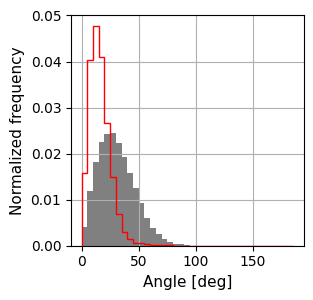

###########################
###########################
###########################


In [42]:
#%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"

names_angle_eval=[["y_test_short_bm_1_0.h5"]]
                  

names_angles="Bound motifs angle"
for i in range(len(names_angle_eval)):
    angle_ds_fused_link_distr_ex_1, values_angle_ds_fused_link_ex1=cg_angle_distr_1_1_bm(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    
    fig1=plt.figure(figsize=(3,3))
    ax1 = fig1.add_subplot(111)

    sel_target_angle_distr=ax1.hist(list_values_target_angles_1[4]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
    sel_angle_distr=ax1.hist(values_angle_ds_fused_link_ex1*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
    print(names_angles)
    ax1.set_ylabel("Normalized frequency",fontsize=11)
    ax1.set_xlabel("Angle [deg]",fontsize=11)
    ax1.grid()
    
    #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_long_1/04-29_Bay_Opt/output_graphics/"
    #angle_name = names_angles[j].lower().replace(" ", "_") 
    #filename = f"{output_dir}/{names_ini1}angle_dist_{i}_{angle_name}.png"

    #plt.savefig(filename, dpi=300, bbox_inches='tight')
            
    plt.show()
  
    print("###########################")
    print("###########################")
    print("###########################")



# Bayesian optimization

## Angle distributions from oxDNA sim

In [9]:
#load target angles
values_angle_base_target=np.load("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining/Y_motif_angles_oxDNA/short_y_motif/values_angles_short_motif/values_angle_base_target.npy")
values_angle_link_target=np.load("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining/Y_motif_angles_oxDNA/short_y_motif/values_angles_short_motif/values_angle_link_target.npy")
values_angle_arm_axis_target=np.load("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining/Y_motif_angles_oxDNA/short_y_motif/values_angles_short_motif/values_angle_arm_axis_target.npy")
values_angle_link_HP_target=np.load("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining/Y_motif_angles_oxDNA/short_y_motif/values_angles_short_motif/values_angle_link_HP_target.npy")
values_angle_ds_fused_link_target=np.load("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining/Y_motif_angles_oxDNA/short_y_motif/values_angles_short_motif/values_angle_ds_fused_link_target.npy")


In [10]:
#generate histograms of target angles
values_angle_base_target=values_angle_base_target.flatten()
values_angle_link_target=values_angle_link_target.flatten()
values_angle_arm_axis_target=values_angle_arm_axis_target.flatten()
values_angle_link_HP_target=values_angle_link_HP_target.flatten()
values_angle_ds_fused_link_target=values_angle_ds_fused_link_target.flatten()
#values_angle_oppa_target=values_angle_oppa_target.flatten()

base_angle_distr_target=np.histogram(values_angle_base_target*180/np.pi,bins=np.arange(0,190,5),density=True)[0]
link_angle_distr_target=np.histogram(values_angle_link_target*180/np.pi,bins=np.arange(0,190,5),density=True)[0]
arm_axis_angle_distr_target=np.histogram(values_angle_arm_axis_target*180/np.pi,bins=np.arange(0,190,1),density=True)[0]
link_HP_angle_distr_target=np.histogram(values_angle_link_HP_target*180/np.pi,bins=np.arange(0,190,5),density=True)[0]
angle_ds_fused_link_distr_target=np.histogram(values_angle_ds_fused_link_target*180/np.pi,bins=np.arange(0,190,5),density=True)[0]
#oppa_angle_distr_target=np.histogram(values_angle_oppa_target*180/np.pi,bins=np.arange(0,190,5),density=True)[0]

base_angle_distr_target=np.asarray(base_angle_distr_target)
link_angle_distr_target=np.asarray(link_angle_distr_target)
arm_axis_angle_distr_target=np.asarray(arm_axis_angle_distr_target)
link_HP_angle_distr_target=np.asarray(link_HP_angle_distr_target)
angle_ds_fused_link_distr_target=np.asarray(angle_ds_fused_link_distr_target)
#oppa_angle_distr_target=np.asarray(oppa_angle_distr_target)

list_values_target_angles_1=[values_angle_base_target,values_angle_link_target,values_angle_arm_axis_target,values_angle_link_HP_target,values_angle_ds_fused_link_target] #values_angle_oppa_target, 

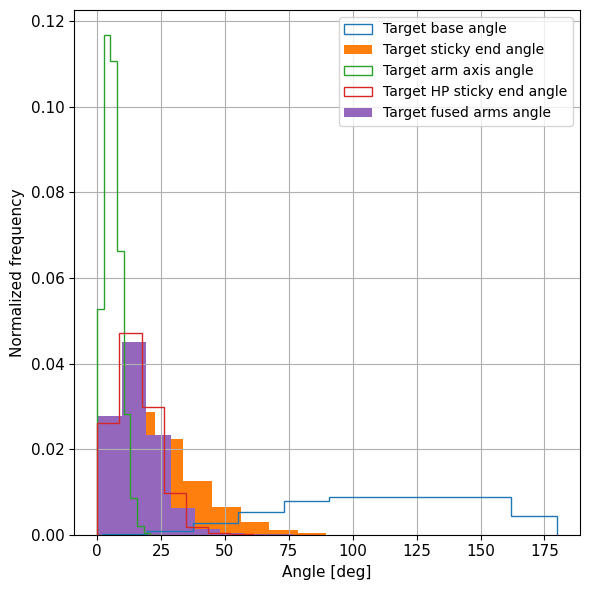

In [11]:
plt.figure(figsize=(6,6))
plt.hist(values_angle_base_target*180/np.pi,density=True,label="Target base angle",histtype="step")
plt.hist(values_angle_link_target*180/np.pi,density=True,label="Target sticky end angle",histtype="bar")
plt.hist(values_angle_arm_axis_target*180/np.pi,density=True,label="Target arm axis angle",histtype="step")
plt.hist(values_angle_link_HP_target*180/np.pi,density=True,label="Target HP sticky end angle",histtype="step")
plt.hist(values_angle_ds_fused_link_target*180/np.pi,density=True,label="Target fused arms angle",histtype="bar")
#plt.hist(values_angle_oppa_target*180/np.pi,density=True,label="Target opposing arm angle",histtype="bar")


plt.legend()
plt.xlabel("Angle [deg]",fontsize=11)
plt.ylabel("Normalized frequency",fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid()
plt.tight_layout()

# Optimize different angle combinations

## Initialize botorch

In [12]:
#use botorch implementation 
#initialize GP model, train on input and predict next params
def apply_gp_bo_1(x_rs,x_train_rs,x,f_train_rs,seed,dim_x,dim_y,num_restarts,raw_samples,scaler_x):
    #x_rs: full rescaled parameter space  -> no actual rescaling needed with internal rescaling by botorch
    #x_train_rs: rescaled training values -> no actual rescaling needed with internal rescaling by botorch
    #x: full non-rescaled parameter space -> only needed to get bounds
    #initialize and train GP model

    #set random seed for torch and numpy, each round gets different seed based on number of rounds
    torch.manual_seed(seed+len(f_train_rs))
    np.random.seed(seed+len(f_train_rs))

    #fit scaler on full range of values
    scaler_x1=scaler_x()
    scaler_x1.fit(x) 
    x=scaler_x1.transform(x)
    #print(x)
    #minimum and maximum values for bounds
    min_bounds = np.min(x, axis=0)
    max_bounds = np.max(x, axis=0)
    bounds = np.vstack((min_bounds, max_bounds))
    #print(bounds)
    bounds = torch.from_numpy(bounds)
    #print(x_train_rs,f_train_rs)

    #x and f as arrays
    x_train_rs=np.array(x_train_rs)
    f_train_rs=np.array(f_train_rs).reshape(-1,1)

    #option to scale input before botorch 
    x_train_rs=scaler_x1.transform(x_train_rs)
    #print(x_train_rs,f_train_rs)

    #x and f as torch tensor
    x_train_rs=torch.from_numpy(x_train_rs)
    f_train_rs=torch.from_numpy(f_train_rs)
    
    #print(x_train_rs.shape,f_train_rs.shape)
    #option to specify noise
    #train_fvar = torch.zeros_like(f_train_rs)  # Zero noise
    #likelihood = FixedNoiseGaussianLikelihood(noise=train_fvar)
    #gp=SingleTaskGP(train_X=x_train_rs,train_Y=f_train_rs,**params_SingleTaskGP_dict)
    gp=SingleTaskGP(train_X=x_train_rs,train_Y=f_train_rs,input_transform=Normalize(d=dim_x),outcome_transform=Standardize(m=dim_y))
    

    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    logEI = LogExpectedImprovement(model=gp, best_f=f_train_rs.max())
    #ei = ExpectedImprovement(model=gp, best_f=f_train_rs.max())
    ucb =UpperConfidenceBound(gp, beta=1)

    candidate, acq_value = optimize_acqf(ucb, bounds=bounds, q=1, num_restarts=num_restarts, raw_samples=raw_samples)

    x_rs_next=candidate.detach().numpy()[0]
    #print(x_rs_next)
    #apply inverse scaling transform
    if dim_x==1:
        x_next=scaler_x1.inverse_transform(x_rs_next.reshape(-1, 1)).flatten()
    else:
        x_next=scaler_x1.inverse_transform(x_rs_next)
    #x_next=x_rs_next
    print(x_rs_next,x_next)
    gpr=None
    
    return x_next, x_next, gpr




In [13]:
#for GP parameter values need to be in other range, for instance [0,5], apply scaler to parameter lists
def rescaled_params_df(df):
    scalers = []
    scaled_values = []

    for values in df['Param values']:
        scaler = MinMaxScaler(feature_range=(0, 5))
        scaled = scaler.fit_transform(np.asarray(values*10**20).reshape(-1, 1)).flatten()
        scalers.append(scaler)
        scaled_values.append(scaled)

    df['Scalers'] = scalers
    df['Rs param values'] = scaled_values
    
    return df

#generate linearly scaled rs values, independent of actual parameter scaling
def rescaled_params_2_df(df):
    scalers = []
    scaled_values = []

    for values in df['Param values']:
        scaler = MinMaxScaler(feature_range=(0, 5))
        values_lin=np.linspace(0,5,len(values))
        scaled = scaler.fit_transform(values_lin.reshape(-1, 1)).flatten()
        scalers.append(scaler)
        scaled_values.append(scaled)

    df['Scalers'] = scalers
    df['Rs param values'] = scaled_values
    
    return df

#place holder rescaling
def rescaled_params_no_sc_df(df):
    scalers = []
    scaled_values = []

    for values in df['Param values']:
        scaler = FunctionTransformer(func=None) #MinMaxScaler(feature_range=(0, 5))
        scaled = scaler.fit_transform(np.asarray(values).reshape(-1, 1)).flatten()
        scalers.append(scaler)
        scaled_values.append(scaled)

    df['Scalers'] = scalers
    df['Rs param values'] = scaled_values
    
    return df


def scale_by_inverse_min(X):
    min_vals = np.min(X, axis=0)
    return X * (1 / min_vals)

#sklearn scaler struggles with small values, use simple implementaion generated with Copilot
class MinMaxScaler2:
    def __init__(self):
        self.data_min = None
        self.data_max = None

    def fit(self, data):
        """
        Compute the minimum and maximum values for scaling.

        Parameters:
        data (numpy.ndarray): The input data to be scaled.
        """
        self.data_min = np.min(data, axis=0)
        self.data_max = np.max(data, axis=0)

    def transform(self, data):
        """
        Scale the data to the range [0, 1].

        Parameters:
        data (numpy.ndarray): The input data to be scaled.

        Returns:
        numpy.ndarray: The scaled data.
        """
        if self.data_min is None or self.data_max is None:
            raise ValueError("The scaler has not been fitted yet.")
        scaled_data = (data - self.data_min) / (self.data_max - self.data_min)
        return scaled_data

    def inverse_transform(self, scaled_data):
        """
        Reverse the scaling of the data.

        Parameters:
        scaled_data (numpy.ndarray): The scaled data to be reverted.

        Returns:
        numpy.ndarray: The Arial data.
        """
        if self.data_min is None or self.data_max is None:
            raise ValueError("The scaler has not been fitted yet.")
        Original_data = scaled_data * (self.data_max - self.data_min) + self.data_min
        return Original_data
        
#apply MinMaxScaler2 to data
def rescaled_params_df_MinMaxScaler2(df):
    scalers = []
    scaled_values = []

    for values in df['Param values']:
        scaler = MinMaxScaler2()
        scaler.fit(np.asarray(values).reshape(-1, 1))
        scaled = scaler.transform(np.asarray(values).reshape(-1, 1)).flatten()
        scalers.append(scaler)
        scaled_values.append(scaled)

    df['Scalers'] = scalers
    df['Rs param values'] = scaled_values
    
    return df

## Base angle

In [14]:
#copy of sim params
run_sim_1_input_1=run_sim_1_input.copy()

#specify which parameters are to be optimised over which range
var_params_1={"Param names":["k_angle_ds_base",
                             "theta_base_x"],
                         
            "Param values":[k_angle_ds_base_range,                           
                            theta_base_x_range],
            
            "Set of indep params":[0,     
                                   0],
           "Index init guess":[[0,0,3,3,2], # nachfragen wie viele werte richtig
                               [0,3,0,3,2],
                              ]
           }

df_var_params_1=pd.DataFrame(var_params_1)

#placeholder scaler on real values
df_var_params_1 = rescaled_params_no_sc_df(df_var_params_1)


df_var_params_1

Param names                                       Param values  \
0  k_angle_ds_base                       [1e-24, 1e-22, 1e-20, 1e-18]   
1     theta_base_x  [1.5707963267948966, 2.0943951023931953, 2.617...   

   Set of indep params Index init guess                Scalers  \
0                    0  [0, 0, 3, 3, 2]  FunctionTransformer()   
1                    0  [0, 3, 0, 3, 2]  FunctionTransformer()   

                                     Rs param values  
0                       [1e-24, 1e-22, 1e-20, 1e-18]  
1  [1.5707963267948966, 2.0943951023931953, 2.617...

In [15]:
#specify evaluation and Bayesian opt parameters for each independent set of parameters
#every independent parameter set needs own dictionaries for GP and eval, as parameters need to be updated independently later
GP_params_1={"x_rs":[[0]],"x_train_rs":[[0]],"x":[[0]],"f_train_rs":[[0]],"seed":1,"dim_x":2,"dim_y":1,"num_restarts":1000,"raw_samples":10000,"scaler_x":MinMaxScaler2}


Eval_params_1={"folder":None,"names_sim_repeat":None,"t_skip":300,"t_lim":None,"t_step":1,
             "base_angle_distr_target":base_angle_distr_target}

eval_opt_param_set_1={"Set of indep params":[0],
                      "Eval fct": [eval_sim_1_1_ba],
                      "Eval params":[Eval_params_1],
                      "Scaler": [FunctionTransformer(func=None)],
                      "GP": [apply_gp_bo_1],
                      "GP params": [GP_params_1]}

df_eval_opt_param_set_1=pd.DataFrame(eval_opt_param_set_1)
df_eval_opt_param_set_1

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_ba at 0x79d11d3d2820>   

                                         Eval params                 Scaler  \
0  {'folder': None, 'names_sim_repeat': None, 't_...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x79d11b1ece50>   

                                           GP params  
0  {'x_rs': [[0]], 'x_train_rs': [[0]], 'x': [[0]...

In [16]:
%%time
#run optimization
df_t1,gpr_1=run_gp_11(df_run_sim=run_sim_1_input_1,
              df_var_params=df_var_params_1,
              fct_sim=run_sim_1,
              df_eval_opt_param_set=df_eval_opt_param_set_1,
              sim_folder="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/",
              sim_name="sim_ba_opt_1_",
              file_name_sim_params=None, #"params_ba_opt_1", 
              sim_repeats=5,
              iterations=50,
              print_sim_config=False,
              load_existing_init_sims=True,
              load_existing_opt_sims=True)

Step  1 / 5  initial simulations
Step  2 / 5  initial simulations
Step  3 / 5  initial simulations
Step  4 / 5  initial simulations
Step  5 / 5  initial simulations
Step  1 / 50  optimization simulations
[1.         0.24161202] [1.0000000e-18 1.9503196e+00]
Step  2 / 50  optimization simulations
[0.99968884 0.60824036] [9.99688840e-19 2.52621805e+00]
Step  3 / 50  optimization simulations
[0.74927381 0.41414253] [7.49274056e-19 2.22132990e+00]
Step  4 / 50  optimization simulations
[0.65803369 0.67220829] [6.58034028e-19 2.62669863e+00]
Step  5 / 50  optimization simulations
[0.33585368 0.51196153] [3.35854349e-19 2.37498362e+00]
Step  6 / 50  optimization simulations
[1.         0.41630477] [1.00000000e-18 2.22472633e+00]
Step  7 / 50  optimization simulations
[0.77916247 0.18173274] [7.79162687e-19 1.85626145e+00]
Step  8 / 50  optimization simulations
[1.         0.80397013] [1.00000000e-18 2.83366966e+00]
Step  9 / 50  optimization simulations
[0.91424917 0.14105746] [9.14249257e-1

In [17]:
df_t1

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_ba at 0x79d11d3d2820>   

                                         Eval params                 Scaler  \
0  {'folder': '/home/xenia/Masterthesis_ReaDDy/Ba...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x79d11b1ece50>   

                                           GP params  \
0  {'x_rs': [[1e-24, 1.5707963267948966], [1e-24,...   

                Param names in set  \
0  [k_angle_ds_base, theta_base_x]   

                                             f train  \
0  [0.9180398210916376, 0.9197161601439799, 0.954...   

                                          f train rs  \
0  [0.9180398210916376, 0.9197161601439799, 0.954...   

                                          x train rs  \
0  [[1e-24, 1.5707963267948966], [1e-24, 3.141592...   

                                             x train  
0  [[1e-24, 1.5707963267948966], [1e-24, 3.141592...

In [18]:
#create dictionary with updated parameters
dict_opt_params_step_1={}
dict_opt_rs_params_step_1={}

for index, row in df_t1.iterrows():
    id_max=np.argmax(row["f train"])
    print("max fitness:",id_max,np.max(row["f train"]))
    opt_params_names=row["Param names in set"]
    opt_params_names_rs=[ e+"_rs" for e in opt_params_names]
    opt_params=row["x train"][id_max]
    opt_params_rs=row["x train rs"][id_max]
    
    for key, value in zip(opt_params_names,opt_params):
        dict_opt_params_step_1[key] = value
    for key, value in zip(opt_params_names_rs,opt_params_rs):
        dict_opt_rs_params_step_1[key] = value    
        
    print("param set:",row["Set of indep params"],row["x train rs"][id_max])
    print("param set:",row["Set of indep params"],row["x train"][id_max])

    
print(dict_opt_rs_params_step_1)    
print(dict_opt_params_step_1)

max fitness: 49 0.9593166123848045
param set: 0 [1.2935935177846317e-19, 2.632120138807939]
param set: 0 [1.2935935177846317e-19, 2.632120138807939]
{'k_angle_ds_base_rs': 1.2935935177846317e-19, 'theta_base_x_rs': 2.632120138807939}
{'k_angle_ds_base': 1.2935935177846317e-19, 'theta_base_x': 2.632120138807939}


Parameter set 0


<Figure size 600x300 with 0 Axes>

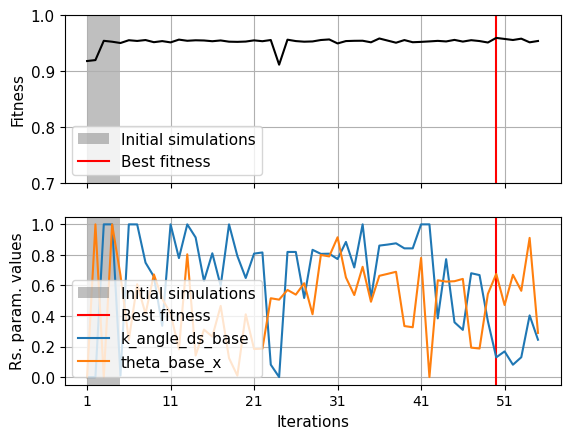

In [19]:
for index, row in df_t1.iterrows():
    fig1=plt.figure(figsize=(6,3))
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    #ax1 = fig1.add_subplot(111)
    fitness_range_l=0.7
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=10
    init_sim_range=5
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1)
    fitnes_range=np.round(np.linspace(fitness_range_l,fitness_range_h,fitness_range_step),1)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    #ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower left",prop={'size': 11})
    ax1.grid()
    
    
    #for j in range(len(row["x train rs"][0])):
       # param_name=row["Param names in set"][j]
       # ax2.errorbar(iterations_l,[sublist[j] for sublist in row["x train rs"]],label=param_name)

    for j in range(len(row["x train rs"][0])):
        param_name=row["Param names in set"][j]
        param_sel=[sublist[j] for sublist in row["x train rs"]]
        scaler_param_sel=MinMaxScaler2()
        param_sel_range=df_var_params_1[df_var_params_1["Param names"]==param_name]["Param values"].to_numpy()[0]
        scaler_param_sel.fit(param_sel_range)
        param_sel_rs=scaler_param_sel.transform(param_sel)
        ax2.errorbar(iterations_l,param_sel_rs,label=param_name)
        
    ax2.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax2.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax2.set_xlabel("Iterations",fontsize=11)
    ax2.set_ylabel("Rs. param. values",fontsize=11)
    #plt.ylim(10**-22,0.1*10**-18)
    ax2.set_yticks(param_value_range,param_value_range,fontsize=11)
    #ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    ax2.legend(loc="lower left",prop={'size': 11})
    ax2.grid()
    
    #Grafik als PNG speichern
    #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
   # filename = f"{output_dir}/sim_ba_opt_1_fitness.png"
   # plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    
    plt.show()

    

Base angle


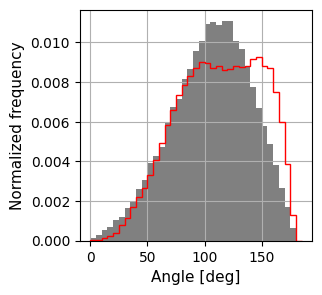

###########################
###########################
###########################
Link angle


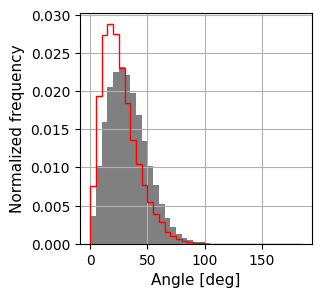

###########################
###########################
###########################
Arm axis angle


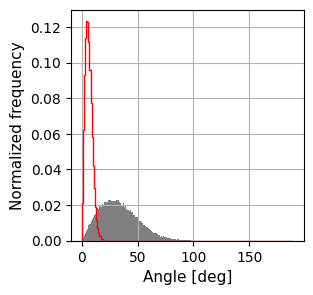

###########################
###########################
###########################
Base angle


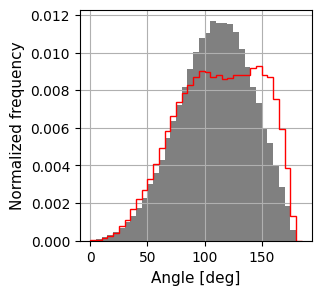

###########################
###########################
###########################
Link angle


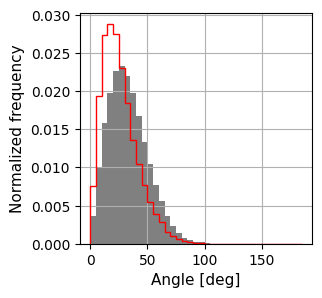

###########################
###########################
###########################
Arm axis angle


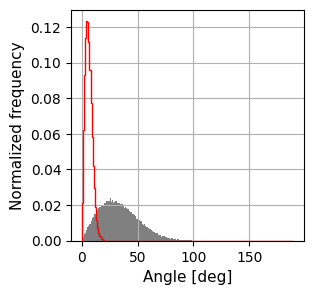

###########################
###########################
###########################
CPU times: user 1.52 s, sys: 3.12 s, total: 4.63 s
Wall time: 5.71 s


In [20]:
%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_ba_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

names_angles=["Base angle", "Link angle","Arm axis angle"]
for i in range(len(names_angle_eval)):
    n1,n2,n3,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1=cg_angle_distr_1_3_ba_aa_la(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    list_angles_eval=[values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1]
    
    for j in range(len(list_angles_eval)):
        fig1=plt.figure(figsize=(3,3))
        ax1 = fig1.add_subplot(111)
        if names_angles[j]=="Arm axis angle":
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='bar',color="grey")[0]
          
        else:
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
        print(names_angles[j])
        ax1.set_ylabel("Normalized frequency",fontsize=11)
        ax1.set_xlabel("Angle [deg]",fontsize=11)
        ax1.grid()
        
       # output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
       # angle_name = names_angles[j].lower().replace(" ", "_") 
       # filename = f"{output_dir}/{names_ini1}angle_dist_{i}_{angle_name}.png"

       # plt.savefig(filename, dpi=300, bbox_inches='tight')
            
        plt.show()
  
        print("###########################")
        print("###########################")
        print("###########################")


In [21]:


folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_ba_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

for i in range(len(names_angle_eval)):
    n1, n2, n3, values_angle_base_ex_1, values_angle_link_ex_1, values_angle_arm_axis_ex_1 = cg_angle_distr_1_3_ba_aa_la(
        folder=folder_names_angle_eval,
        names_sim_repeat=names_angle_eval[i],
        t_skip=300,
        t_lim=None,
        t_step=1
    )

    # Base angle analysieren (Radiant -> Grad)
    base_angles_sim = values_angle_base_ex_1 * 180 / np.pi
    base_angles_target = list_values_target_angles_1[0] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(base_angles_sim, base_angles_target)
    print(f"Datensatz {i+1}:")
    print(f"  Kolmogorov-Smirnov-Test (Base angle): Statistik={ks_stat:.4f}, p-Wert={ks_p:.4e}")

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(base_angles_sim, base_angles_target)
    print(f"  Wasserstein-Distanz (Base angle): {wass_dist:.4f} Grad\n")

Datensatz 1:
  Kolmogorov-Smirnov-Test (Base angle): Statistik=0.1044, p-Wert=0.0000e+00
  Wasserstein-Distanz (Base angle): 6.7326 Grad

Datensatz 2:
  Kolmogorov-Smirnov-Test (Base angle): Statistik=0.0939, p-Wert=0.0000e+00
  Wasserstein-Distanz (Base angle): 4.7064 Grad



In [22]:


folder_names_angle_eval = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"
names_ini1 = "sim_ba_opt_1_"

# Alle Dateien im Ordner mit dem gewünschten Präfix und Suffix suchen
file_list = sorted([
    f for f in os.listdir(folder_names_angle_eval)
    if f.startswith(names_ini1) and f.endswith('.h5')
])

# Zielwinkel, anpassen je nach Kontext!
# list_values_target_angles_1 = [ ... ]
# Beispiel:
# list_values_target_angles_1 = [np.array([...])]

# Ergebnisliste für die Tabelle
results = []

for fname in file_list:
    # Simulation auswerten
    n1, n2, n3, values_angle_base_ex_1, values_angle_link_ex_1, values_angle_arm_axis_ex_1 = cg_angle_distr_1_3_ba_aa_la(
        folder=folder_names_angle_eval,
        names_sim_repeat=[fname],  # Liste mit einer Datei
        t_skip=300,
        t_lim=None,
        t_step=1
    )

    # Base angle analysieren (Radiant -> Grad)
    base_angles_sim = values_angle_base_ex_1 * 180 / np.pi
    base_angles_target = list_values_target_angles_1[0] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(base_angles_sim, base_angles_target)

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(base_angles_sim, base_angles_target)

    # Ergebnisse speichern
    results.append({
        'Simulation': fname,
        'KS_Distanz': ks_stat,
        'p_Wert': ks_p,
        'Wasserstein_Distanz': wass_dist
    })

# In DataFrame umwandeln und anzeigen/speichern
df = pd.DataFrame(results, columns=['Simulation', 'KS_Distanz', 'p_Wert', 'Wasserstein_Distanz'])
print(df)

# Optional als CSV speichern:
# df.to_csv('angle_tests_results.csv', index=False)

              Simulation  KS_Distanz         p_Wert  Wasserstein_Distanz
0      sim_ba_opt_1_1.h5    0.255119   0.000000e+00            24.960779
1     sim_ba_opt_1_10.h5    0.246110   0.000000e+00            25.126834
2    sim_ba_opt_1_100.h5    0.096137  4.282602e-104             5.222931
3    sim_ba_opt_1_101.h5    0.079928   4.831298e-72             4.345961
4    sim_ba_opt_1_102.h5    0.077670   4.772818e-68             3.932888
..                   ...         ...            ...                  ...
270   sim_ba_opt_1_95.h5    0.095080  7.997167e-102             5.439624
271   sim_ba_opt_1_96.h5    0.084701   7.290858e-81             4.882331
272   sim_ba_opt_1_97.h5    0.090808   6.679225e-93             5.169974
273   sim_ba_opt_1_98.h5    0.095091  7.591567e-102             5.672643
274   sim_ba_opt_1_99.h5    0.084721   6.688817e-81             5.392266

[275 rows x 4 columns]


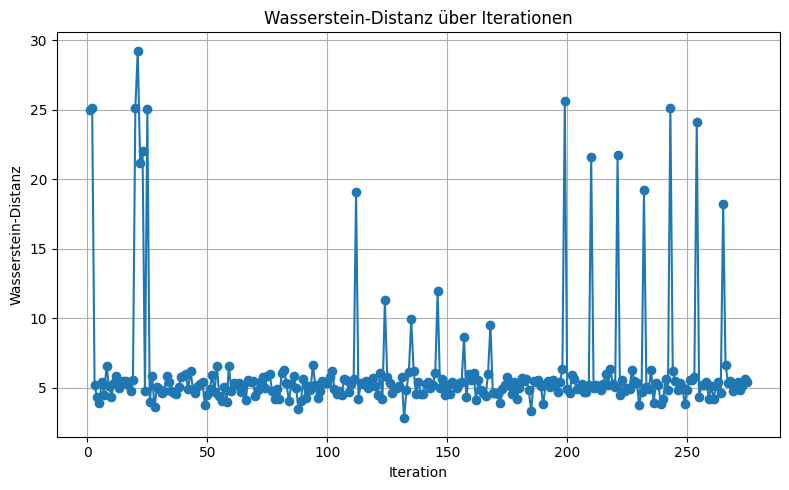

In [23]:
# Falls dein DataFrame df noch nicht die Iterationsspalte hat:
df = df.reset_index(drop=True)
df['Iteration'] = df.index + 1  # Startet bei 1, alternativ bei 0: df.index

plt.figure(figsize=(8, 5))
plt.plot(df['Iteration'], df['Wasserstein_Distanz'], marker='o')
plt.xlabel('Iteration')
plt.ylabel('Wasserstein-Distanz')
plt.title('Wasserstein-Distanz über Iterationen')
plt.grid(True)
plt.tight_layout()
plt.show()

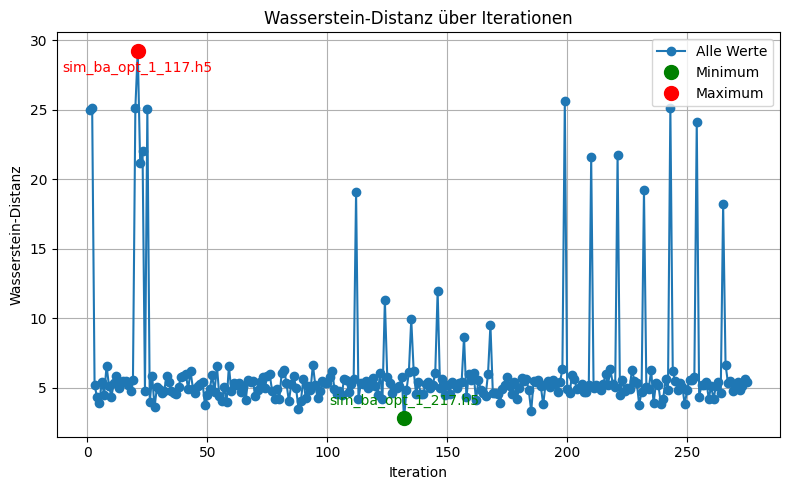

In [26]:

df = df.reset_index(drop=True)
df['Iteration'] = df.index + 1

# Index von Min und Max finden
idx_min = df['Wasserstein_Distanz'].idxmin()
idx_max = df['Wasserstein_Distanz'].idxmax()

plt.figure(figsize=(8, 5))
plt.plot(df['Iteration'], df['Wasserstein_Distanz'], marker='o', label='Alle Werte')

# Alle Punkte plotten
plt.plot(df.loc[idx_min, 'Iteration'], df.loc[idx_min, 'Wasserstein_Distanz'],
         'go', markersize=10, label='Minimum')
plt.plot(df.loc[idx_max, 'Iteration'], df.loc[idx_max, 'Wasserstein_Distanz'],
         'ro', markersize=10, label='Maximum')

# Namen der Simulationen annotieren
plt.annotate(df.loc[idx_min, 'Simulation'],
             (df.loc[idx_min, 'Iteration'], df.loc[idx_min, 'Wasserstein_Distanz']),
             textcoords="offset points", xytext=(0,10), ha='center', color='green', fontsize=10)
plt.annotate(df.loc[idx_max, 'Simulation'],
             (df.loc[idx_max, 'Iteration'], df.loc[idx_max, 'Wasserstein_Distanz']),
             textcoords="offset points", xytext=(0,-15), ha='center', color='red', fontsize=10)

plt.xlabel('Iteration')
plt.ylabel('Wasserstein-Distanz')
plt.title('Wasserstein-Distanz über Iterationen')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

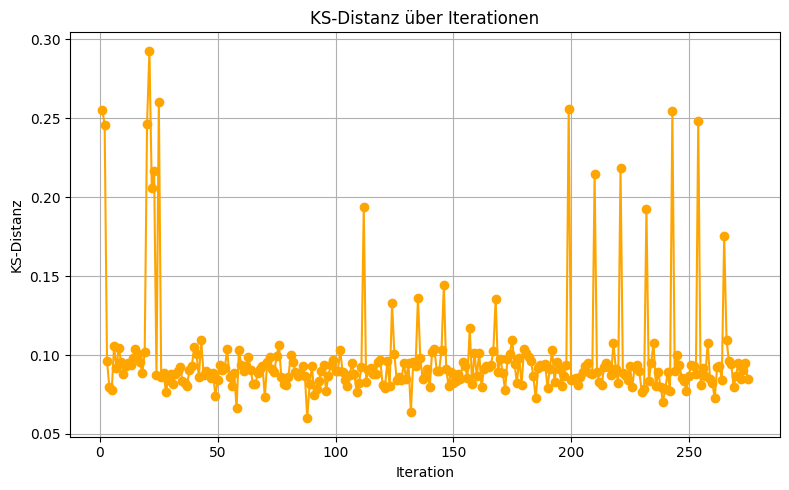

In [24]:
import matplotlib.pyplot as plt

# Falls dein DataFrame df noch nicht die Iterationsspalte hat:
df = df.reset_index(drop=True)
df['Iteration'] = df.index + 1  # Startet bei 1

plt.figure(figsize=(8, 5))
plt.plot(df['Iteration'], df['KS_Distanz'], marker='o', color='orange')
plt.xlabel('Iteration')
plt.ylabel('KS-Distanz')
plt.title('KS-Distanz über Iterationen')
plt.grid(True)
plt.tight_layout()
plt.show()

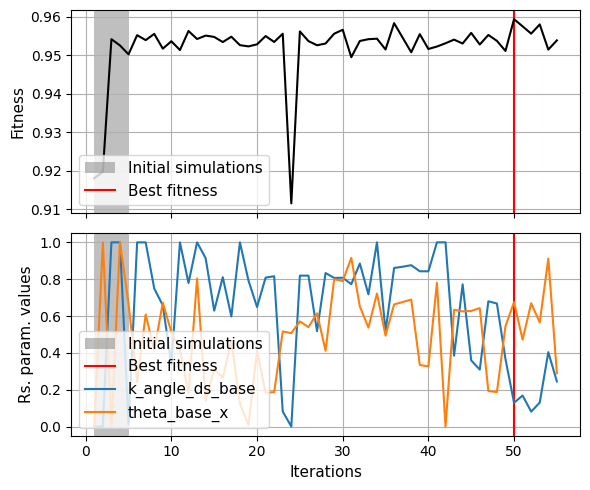

In [25]:
class MinMaxScaler2:
    def fit(self, arr):
        self.min_ = np.min(arr)
        self.max_ = np.max(arr)
    def transform(self, values):
        arr = np.array(values)
        return (arr - self.min_) / (self.max_ - self.min_)

# Beispiel-Loop für DataFrame df_t1
for idx, row in df_t1.iterrows():
    # Vorbereitung
    iters = np.arange(1, len(row["f train"]) + 1)
    best_idx = np.argmax(row["f train"])
    param_names = row["Param names in set"]
    init_sim_range = 5

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 5))

    # --- Fitness ---
    ax1.errorbar(iters, row["f train"], color="black")
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5, label="Initial simulations")
    ax1.axvline(iters[best_idx], color="red", label="Best fitness")
    ax1.set_ylabel("Fitness", fontsize=11)
    ax1.legend(loc="lower left", prop={'size': 11})
    ax1.grid(True)

    # --- Parameterwerte (reskaliert) ---
    for j, pname in enumerate(param_names):
        param_values = [sublist[j] for sublist in row["x train rs"]]
        scaler = MinMaxScaler2()
        param_range = df_var_params_1[df_var_params_1["Param names"] == pname]["Param values"].to_numpy()[0]
        scaler.fit(param_range)
        param_scaled = scaler.transform(param_values)
        ax2.errorbar(iters, param_scaled, label=pname)
    
    ax2.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5, label="Initial simulations")
    ax2.axvline(iters[best_idx], color="red", label="Best fitness")
    ax2.set_xlabel("Iterations", fontsize=11)
    ax2.set_ylabel("Rs. param. values", fontsize=11)
    ax2.legend(loc="lower left", prop={'size': 11})
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [27]:
values_angle_base_target

array([1.46657709, 2.42812539, 2.24920296, ..., 2.83057343, 1.67920686,
       1.77309523])

## Arm axis angle

In [22]:
#copy of sim params
run_sim_1_input_2=run_sim_1_input.copy()

#update parameters optimized in previous step
run_sim_1_input_2.update(dict_opt_params_step_1)

#specify which parameters are to be optimised over which range
var_params_2={"Param names":["k_angle_ds_arm"],
                         
            "Param values":[k_angle_ds_arm_range],
            
            "Set of indep params":[0],
           "Index init guess":[[0,3]] #[1,8]
           }

df_var_params_2=pd.DataFrame(var_params_2)



#placeholder scaler on real values
df_var_params_2 = rescaled_params_no_sc_df(df_var_params_2)


df_var_params_2

Param names                  Param values  Set of indep params  \
0  k_angle_ds_arm  [1e-24, 1e-22, 1e-20, 1e-18]                    0   

  Index init guess                Scalers               Rs param values  
0           [0, 3]  FunctionTransformer()  [1e-24, 1e-22, 1e-20, 1e-18]

In [23]:
#specify evaluation and Bayesian opt parameters for each independent set of parameters
#every independent parameter set needs own dictionaries for GP and eval, as parameters need to be updated independently later


GP_params_2={"x_rs":[[0]],"x_train_rs":[[0]],"x":[[0]],"f_train_rs":[[0]],"seed":1,"dim_x":1,"dim_y":1,"num_restarts":100,"raw_samples":1000,"scaler_x":MinMaxScaler2}


Eval_params_2={"folder":None,"names_sim_repeat":None,"t_skip":300,"t_lim":None,"t_step":1,
             "arm_axis_angle_distr_target":arm_axis_angle_distr_target}

eval_opt_param_set_2={"Set of indep params":[0],
                      "Eval fct": [eval_sim_1_1_aa],
                      "Eval params":[Eval_params_2],
                      "Scaler": [FunctionTransformer(func=None)],
                      "GP": [apply_gp_bo_1],
                      "GP params": [GP_params_2]}

df_eval_opt_param_set_2=pd.DataFrame(eval_opt_param_set_2)
df_eval_opt_param_set_2

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_aa at 0x70a4e6cae940>   

                                         Eval params                 Scaler  \
0  {'folder': None, 'names_sim_repeat': None, 't_...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x70a600f89f70>   

                                           GP params  
0  {'x_rs': [[0]], 'x_train_rs': [[0]], 'x': [[0]...

In [24]:
%%time
#run optimization
df_t2,gpr_2=run_gp_11(df_run_sim=run_sim_1_input_2,
              df_var_params=df_var_params_2,
              fct_sim=run_sim_1,
              df_eval_opt_param_set=df_eval_opt_param_set_2,
              sim_folder="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/",
              sim_name="sim_aa_opt_1_",
              file_name_sim_params=None, #"params_aa_opt_1", 
              sim_repeats=5,
              iterations=50,
              print_sim_config=False,
              load_existing_init_sims=True,
              load_existing_opt_sims=True)

Step  1 / 2  initial simulations
Step  2 / 2  initial simulations
Step  1 / 50  optimization simulations
[0.69999222] [6.99992519e-19]
Step  2 / 50  optimization simulations
[0.56660241] [5.66602841e-19]
Step  3 / 50  optimization simulations
[0.4829514] [4.8295192e-19]
Step  4 / 50  optimization simulations
[0.40077547] [4.0077607e-19]
Step  5 / 50  optimization simulations
[0.32808222] [3.2808289e-19]
Step  6 / 50  optimization simulations
[0.28631338] [2.86314093e-19]
Step  7 / 50  optimization simulations
[0.34548191] [3.45482569e-19]
Step  8 / 50  optimization simulations
[0.34497968] [3.44980333e-19]
Step  9 / 50  optimization simulations
[0.34929034] [3.4929099e-19]
Step  10 / 50  optimization simulations
[0.34626149] [3.46262144e-19]
Step  11 / 50  optimization simulations
[0.34629669] [3.46297341e-19]
Step  12 / 50  optimization simulations
[0.34600207] [3.46002719e-19]
Step  13 / 50  optimization simulations
[0.34535017] [3.45350825e-19]
Step  14 / 50  optimization simulation

In [25]:
df_t2

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_aa at 0x70a4e6cae940>   

                                         Eval params                 Scaler  \
0  {'folder': '/home/xenia/Masterthesis_ReaDDy/Ba...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x70a600f89f70>   

                                           GP params Param names in set  \
0  {'x_rs': [[1e-24], [1e-22], [1e-20], [1e-18]],...   [k_angle_ds_arm]   

                                             f train  \
0  [0.3397772027818952, 0.6380258010857871, 0.704...   

                                          f train rs  \
0  [0.3397772027818952, 0.6380258010857871, 0.704...   

                                          x train rs  \
0  [[1e-24], [1e-18], [6.999925189590242e-19], [5...   

                                             x train  
0  [[1e-24], [1e-18], [6.999925189590242e-19], [5...

In [26]:
#create dictionary with updated parameters
dict_opt_params_step_2={}
dict_opt_rs_params_step_2={}

for index, row in df_t2.iterrows():
    id_max=np.argmax(row["f train"])
    print("max fitness:",id_max,np.max(row["f train"]))
    opt_params_names=row["Param names in set"]
    opt_params_names_rs=[ e+"_rs" for e in opt_params_names]
    opt_params=row["x train"][id_max]
    opt_params_rs=row["x train rs"][id_max]
    
    for key, value in zip(opt_params_names,opt_params):
        dict_opt_params_step_2[key] = value
    for key, value in zip(opt_params_names_rs,opt_params_rs):
        dict_opt_rs_params_step_2[key] = value    
        
    print("param set:",row["Set of indep params"],row["x train rs"][id_max])
    print("param set:",row["Set of indep params"],row["x train"][id_max])

    
print(dict_opt_rs_params_step_2)    
print(dict_opt_params_step_2)

max fitness: 51 0.988977467098975
param set: 0 [3.428857266295872e-19]
param set: 0 [3.428857266295872e-19]
{'k_angle_ds_arm_rs': 3.428857266295872e-19}
{'k_angle_ds_arm': 3.428857266295872e-19}


Parameter set 0


<Figure size 600x300 with 0 Axes>

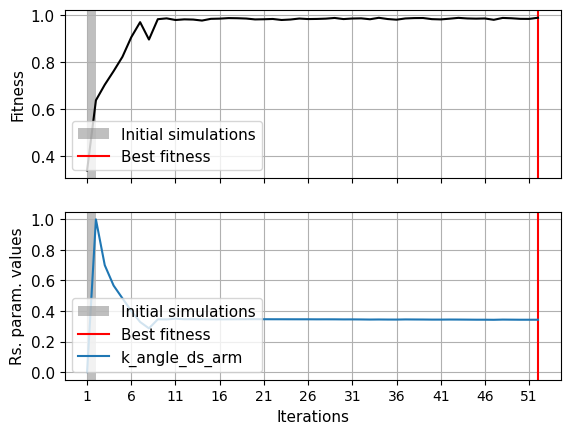

In [27]:
for index, row in df_t2.iterrows():
    fig1=plt.figure(figsize=(6,3))
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    #ax1 = fig1.add_subplot(111)
    fitness_range_l=0.4
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=5
    init_sim_range=2
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1) 
    fitnes_range=np.linspace(fitness_range_l,fitness_range_h,fitness_range_step)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    #ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower left",prop={'size': 11})
    ax1.grid()
    
    
    #for j in range(len(row["x train"][0])):
      #  param_name=row["Param names in set"][j]
       # ax2.errorbar(iterations_l,[sublist[j] for sublist in row["x train"]],label=param_name)
    
    for j in range(len(row["x train rs"][0])):
        param_name=row["Param names in set"][j]
        param_sel=[sublist[j] for sublist in row["x train rs"]]
        scaler_param_sel=MinMaxScaler2()
        param_sel_range=df_var_params_2[df_var_params_2["Param names"]==param_name]["Param values"].to_numpy()[0]
        scaler_param_sel.fit(param_sel_range)
        param_sel_rs=scaler_param_sel.transform(param_sel)
        ax2.errorbar(iterations_l,param_sel_rs,label=param_name)
        
    ax2.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax2.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax2.set_xlabel("Iterations",fontsize=11)
    ax2.set_ylabel("Rs. param. values",fontsize=11)
    ax2.set_yticks(param_value_range,param_value_range,fontsize=11)
    #ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    ax2.legend(loc="lower left",prop={'size': 11})
    ax2.grid()
    
    #Grafik als PNG speichern
    output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
    filename = f"{output_dir}/sim_aa_opt_1_fitness.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    
    plt.show()

    

Base angle


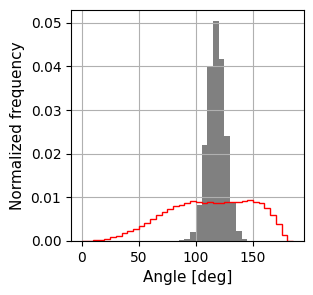

###########################
###########################
###########################
Link angle


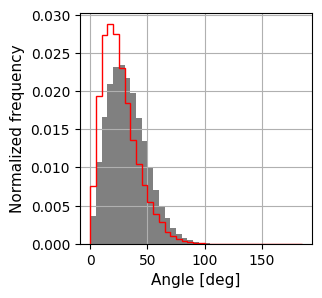

###########################
###########################
###########################
Arm axis angle


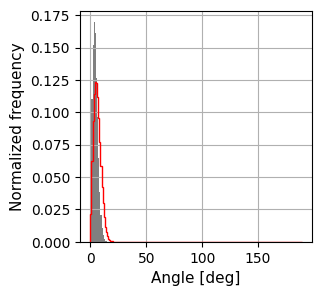

###########################
###########################
###########################
Base angle


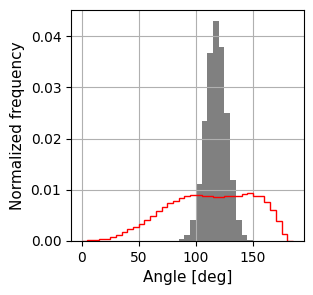

###########################
###########################
###########################
Link angle


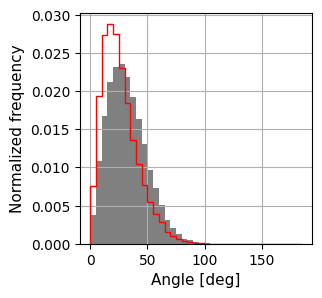

###########################
###########################
###########################
Arm axis angle


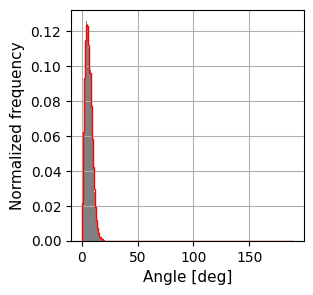

###########################
###########################
###########################
CPU times: user 1.41 s, sys: 3.07 s, total: 4.49 s
Wall time: 4.93 s


In [28]:
%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_aa_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

names_angles=["Base angle", "Link angle","Arm axis angle"]
for i in range(len(names_angle_eval)):
    n1,n2,n3,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1=cg_angle_distr_1_3_ba_aa_la(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    list_angles_eval=[values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1]#,values_angle_oppa_ex_test_1]
    
    for j in range(len(list_angles_eval)):
        fig1=plt.figure(figsize=(3,3))
        ax1 = fig1.add_subplot(111)
        if names_angles[j]=="Arm axis angle":
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='bar',color="grey")[0]
            #plt.xlim(-1,20)
        else:
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
        print(names_angles[j])
        ax1.set_ylabel("Normalized frequency",fontsize=11)
        ax1.set_xlabel("Angle [deg]",fontsize=11)
        ax1.grid()
        
        #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
        #angle_name = names_angles[j].lower().replace(" ", "_") 
        #filename = f"{output_dir}/{names_ini1}angle_dist_{i}_{angle_name}.png"

        #plt.savefig(filename, dpi=300, bbox_inches='tight')
            
        plt.show()
  
        print("###########################")
        print("###########################")
        print("###########################")


In [29]:
folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_aa_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

for i in range(len(names_angle_eval)):
    n1, n2, n3, values_angle_base_ex_1, values_angle_link_ex_1, values_angle_arm_axis_ex_1 = cg_angle_distr_1_3_ba_aa_la(
        folder=folder_names_angle_eval,
        names_sim_repeat=names_angle_eval[i],
        t_skip=300,
        t_lim=None,
        t_step=1
    )

    # Arm axis angle analysieren (Radiant -> Grad)
    arm_axis_angles_sim = values_angle_arm_axis_ex_1 * 180 / np.pi
    arm_axis_angles_target = list_values_target_angles_1[2] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(arm_axis_angles_sim, arm_axis_angles_target)
    print(f"Datensatz {i+1}:")
    print(f"  Kolmogorov-Smirnov-Test (Arm axis angle): Statistik={ks_stat:.4f}, p-Wert={ks_p:.4e}")

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(arm_axis_angles_sim, arm_axis_angles_target)
    print(f"  Wasserstein-Distanz (Arm axis angle): {wass_dist:.4f} Grad\n")

Datensatz 1:
  Kolmogorov-Smirnov-Test (Arm axis angle): Statistik=0.2248, p-Wert=0.0000e+00
  Wasserstein-Distanz (Arm axis angle): 1.6314 Grad

Datensatz 2:
  Kolmogorov-Smirnov-Test (Arm axis angle): Statistik=0.0049, p-Wert=2.0560e-01
  Wasserstein-Distanz (Arm axis angle): 0.0382 Grad



## HP sticky end angle

In [30]:
#copy of sim params
run_sim_1_input_3=run_sim_1_input.copy()

#update parameters optimized in previous step
run_sim_1_input_3.update(dict_opt_params_step_1)
run_sim_1_input_3.update(dict_opt_params_step_2)

#need HP template
run_sim_1_input_3["use_y_1_HP_template"]=True

#specify which parameters are to be optimised over which range
var_params_3={"Param names":["k_angle_ds_hp"],
                         
            "Param values":[k_angle_ds_hp_range],
            
            "Set of indep params":[0],
           "Index init guess":[[0,3]]  #[1,8]
           }

df_var_params_3=pd.DataFrame(var_params_3)

#placeholder scaler on real values
df_var_params_3 = rescaled_params_no_sc_df(df_var_params_3)

df_var_params_3

Param names                  Param values  Set of indep params  \
0  k_angle_ds_hp  [1e-24, 1e-22, 1e-20, 1e-18]                    0   

  Index init guess                Scalers               Rs param values  
0           [0, 3]  FunctionTransformer()  [1e-24, 1e-22, 1e-20, 1e-18]

In [31]:
#specify evaluation and Bayesian opt parameters for each independent set of parameters
#every independent parameter set needs own dictionaries for GP and eval, as parameters need to be updated independently later
GP_params_3={"x_rs":[[0]],"x_train_rs":[[0]],"x":[[0]],"f_train_rs":[[0]],"seed":1,"dim_x":1,"dim_y":1,"num_restarts":100,"raw_samples":1000,"scaler_x":MinMaxScaler2}


Eval_params_3={"folder":None,"names_sim_repeat":None,"t_skip":300,"t_lim":None,"t_step":1,
             "link_HP_angle_distr_target":link_HP_angle_distr_target}

eval_opt_param_set_3={"Set of indep params":[0],
                      "Eval fct": [eval_sim_1_1_hp],
                      "Eval params":[Eval_params_3],
                      "Scaler": [StandardScaler()],
                      "GP": [apply_gp_bo_1],
                      "GP params": [GP_params_3]}

df_eval_opt_param_set_3=pd.DataFrame(eval_opt_param_set_3)
df_eval_opt_param_set_3

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_hp at 0x70a4e6cae9d0>   

                                         Eval params            Scaler  \
0  {'folder': None, 'names_sim_repeat': None, 't_...  StandardScaler()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x70a600f89f70>   

                                           GP params  
0  {'x_rs': [[0]], 'x_train_rs': [[0]], 'x': [[0]...

In [32]:
#run optimization
df_t3,gpr_3=run_gp_11(df_run_sim=run_sim_1_input_3,
              df_var_params=df_var_params_3,
              fct_sim=run_sim_1,
              df_eval_opt_param_set=df_eval_opt_param_set_3,
              sim_folder="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/",
              sim_name="sim_hp_opt_1_",
              file_name_sim_params=None, #"params_hp_opt_1", 
              sim_repeats=5,
              iterations=50,
              print_sim_config=False,
              load_existing_init_sims=True,
              load_existing_opt_sims=True)

Step  1 / 2  initial simulations
Step  2 / 2  initial simulations
Step  1 / 50  optimization simulations
[0.69999222] [6.99992519e-19]
Step  2 / 50  optimization simulations
[0.83693429] [8.36934456e-19]
Step  3 / 50  optimization simulations
[0.60248662] [6.02487015e-19]
Step  4 / 50  optimization simulations
[0.50509992] [5.05100411e-19]
Step  5 / 50  optimization simulations
[0.420069] [4.20069583e-19]
Step  6 / 50  optimization simulations
[0.35751492] [3.57515566e-19]
Step  7 / 50  optimization simulations
[0.30265593] [3.02656629e-19]
Step  8 / 50  optimization simulations
[0.24981598] [2.49816731e-19]
Step  9 / 50  optimization simulations
[0.21324324] [2.13244027e-19]
Step  10 / 50  optimization simulations
[0.18139827] [1.81399088e-19]
Step  11 / 50  optimization simulations
[0.15514346] [1.55144307e-19]
Step  12 / 50  optimization simulations
[0.13865485] [1.38655713e-19]
Step  13 / 50  optimization simulations
[0.1279163] [1.27917174e-19]
Step  14 / 50  optimization simulati

In [33]:
#create dictionary with updated parameters
dict_opt_params_step_3={}
dict_opt_rs_params_step_3={}

for index, row in df_t3.iterrows():
    id_max=np.argmax(row["f train"])
    print("max fitness:",id_max,np.max(row["f train"]))
    opt_params_names=row["Param names in set"]
    opt_params_names_rs=[ e+"_rs" for e in opt_params_names]
    opt_params=row["x train"][id_max]
    opt_params_rs=row["x train rs"][id_max]
    
    for key, value in zip(opt_params_names,opt_params):
        dict_opt_params_step_3[key] = value
    for key, value in zip(opt_params_names_rs,opt_params_rs):
        dict_opt_rs_params_step_3[key] = value    
        
    print("param set:",row["Set of indep params"],row["x train rs"][id_max])
    print("param set:",row["Set of indep params"],row["x train"][id_max])

    
print(dict_opt_rs_params_step_3)    
print(dict_opt_params_step_3)

max fitness: 35 0.9985185728914179
param set: 0 [4.828984582748653e-20]
param set: 0 [4.828984582748653e-20]
{'k_angle_ds_hp_rs': 4.828984582748653e-20}
{'k_angle_ds_hp': 4.828984582748653e-20}


Parameter set 0


<Figure size 600x300 with 0 Axes>

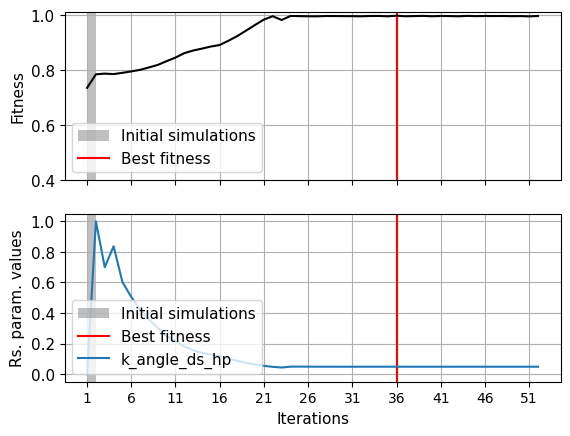

In [34]:
for index, row in df_t3.iterrows():
    fig1=plt.figure(figsize=(6,3))
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    #ax1 = fig1.add_subplot(111)
    fitness_range_l=0.4
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=5
    init_sim_range=2
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1) 
    fitnes_range=np.linspace(fitness_range_l,fitness_range_h,fitness_range_step)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    #ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower left",prop={'size': 11})
    ax1.grid()
    
    
    #for j in range(len(row["x train"][0])):
      #  param_name=row["Param names in set"][j]
       # ax2.errorbar(iterations_l,[sublist[j] for sublist in row["x train"]],label=param_name)
    for j in range(len(row["x train rs"][0])):
        param_name=row["Param names in set"][j]
        param_sel=[sublist[j] for sublist in row["x train rs"]]
        scaler_param_sel=MinMaxScaler2()
        param_sel_range=df_var_params_3[df_var_params_3["Param names"]==param_name]["Param values"].to_numpy()[0]
        scaler_param_sel.fit(param_sel_range)
        param_sel_rs=scaler_param_sel.transform(param_sel)
        ax2.errorbar(iterations_l,param_sel_rs,label=param_name)
        
    ax2.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax2.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax2.set_xlabel("Iterations",fontsize=11)
    ax2.set_ylabel("Rs. param. values",fontsize=11)
    ax2.set_yticks(param_value_range,param_value_range,fontsize=11)
    #ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    ax2.legend(loc="lower left",prop={'size': 11})
    ax2.grid()
    
    #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
    #filename = f"{output_dir}/sim_hp_opt_1_fitness.png"
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()


Link HP angle


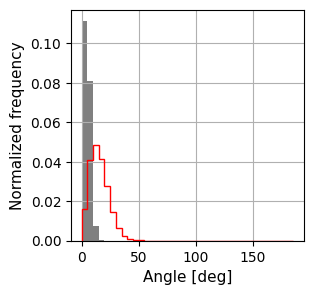

###########################
###########################
###########################
Link HP angle


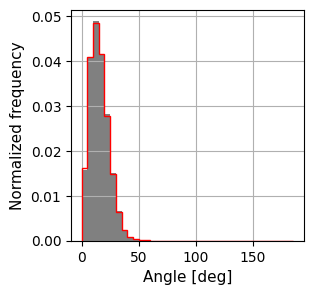

###########################
###########################
###########################
CPU times: user 571 ms, sys: 2.21 s, total: 2.78 s
Wall time: 4.4 s


In [35]:
%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_hp_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

names_angles="Link HP angle"
for i in range(len(names_angle_eval)):
    link_angle_distr_ex_1, values_angle_link_ex1=cg_angle_distr_1_1_hp(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    
    fig1=plt.figure(figsize=(3,3))
    ax1 = fig1.add_subplot(111)

    sel_target_angle_distr=ax1.hist(list_values_target_angles_1[3]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
    sel_angle_distr=ax1.hist(values_angle_link_ex1*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
    print(names_angles)
    ax1.set_ylabel("Normalized frequency",fontsize=11)
    ax1.set_xlabel("Angle [deg]",fontsize=11)
    ax1.grid()
    
    #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
    #angle_name = names_angles[j].lower().replace(" ", "_") 
    #filename = f"{output_dir}/{names_ini1}angle_dist_{i}_{angle_name}.png"

    #plt.savefig(filename, dpi=300, bbox_inches='tight')
            
    plt.show()
  
    print("###########################")
    print("###########################")
    print("###########################")


In [36]:
folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_hp_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

names_angles="Link HP angle"
for i in range(len(names_angle_eval)):
    link_angle_distr_ex_1, values_angle_link_ex1=cg_angle_distr_1_1_hp(
        folder=folder_names_angle_eval,
        names_sim_repeat=names_angle_eval[i],
        t_skip=300,
        t_lim=None,
        t_step=1)
    
    
    # Link angle analysieren (Radiant -> Grad)
    link_angles_sim = values_angle_link_ex1 * 180 / np.pi
    link_angles_target = list_values_target_angles_1[3] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(link_angles_sim, link_angles_target)
    print(f"Datensatz {i+1}:")
    print(f"  Kolmogorov-Smirnov-Test (Link angle): Statistik={ks_stat:.4f}, p-Wert={ks_p:.4e}")

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(link_angles_sim, link_angles_target)
    print(f"  Wasserstein-Distanz (Link angle): {wass_dist:.4f} Grad\n")

Datensatz 1:
  Kolmogorov-Smirnov-Test (Link angle): Statistik=0.6896, p-Wert=0.0000e+00
  Wasserstein-Distanz (Link angle): 10.5181 Grad

Datensatz 2:
  Kolmogorov-Smirnov-Test (Link angle): Statistik=0.0056, p-Wert=1.3953e-01
  Wasserstein-Distanz (Link angle): 0.1217 Grad



## Non-HP Sticky end angle

In [37]:
#copy of sim params
run_sim_1_input_4=run_sim_1_input.copy()

#update parameters optimized in previous step
run_sim_1_input_4.update(dict_opt_params_step_1)
run_sim_1_input_4.update(dict_opt_params_step_2)
run_sim_1_input_4.update(dict_opt_params_step_3)

#specify which parameters are to be optimised over which range
var_params_4={"Param names":["k_angle_ss_link"],
                         
            "Param values":[k_angle_ss_link_range],
            
            "Set of indep params":[0],
           "Index init guess":[[0,0,0,3,2]]
           }

df_var_params_4=pd.DataFrame(var_params_4)

#placeholder scaler on real values
df_var_params_4 = rescaled_params_no_sc_df(df_var_params_4)


df_var_params_4

Param names                  Param values  Set of indep params  \
0  k_angle_ss_link  [1e-24, 1e-22, 1e-20, 1e-18]                    0   

  Index init guess                Scalers               Rs param values  
0  [0, 0, 0, 3, 2]  FunctionTransformer()  [1e-24, 1e-22, 1e-20, 1e-18]

In [38]:
#specify evaluation and Bayesian opt parameters for each independent set of parameters
#every independent parameter set needs own dictionaries for GP and eval, as parameters need to be updated independently later
GP_params_4={"x_rs":[[0]],"x_train_rs":[[0]],"x":[[0]],"f_train_rs":[[0]],"seed":1,"dim_x":1,"dim_y":1,"num_restarts":1000,"raw_samples":10000,"scaler_x":MinMaxScaler2}


Eval_params_4={"folder":None,"names_sim_repeat":None,"t_skip":300,"t_lim":None,"t_step":1,
             "link_angle_distr_target":link_angle_distr_target}

eval_opt_param_set_4={"Set of indep params":[0],
                      "Eval fct": [eval_sim_1_1_la],
                      "Eval params":[Eval_params_4],
                      "Scaler": [FunctionTransformer(func=None)],
                      "GP": [apply_gp_bo_1],
                      "GP params": [GP_params_4]}

df_eval_opt_param_set_4=pd.DataFrame(eval_opt_param_set_4)
df_eval_opt_param_set_4

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_la at 0x70a4e6cae8b0>   

                                         Eval params                 Scaler  \
0  {'folder': None, 'names_sim_repeat': None, 't_...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x70a600f89f70>   

                                           GP params  
0  {'x_rs': [[0]], 'x_train_rs': [[0]], 'x': [[0]...

In [39]:
%%time
#run optimization
df_t4,gpr_4=run_gp_11(df_run_sim=run_sim_1_input_4,
              df_var_params=df_var_params_4,
              fct_sim=run_sim_1,
              df_eval_opt_param_set=df_eval_opt_param_set_4,
              sim_folder="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/",
              sim_name="sim_la_opt_1_",
              file_name_sim_params=None, #"params_la_opt_1", 
              sim_repeats=5,
              iterations=50,
              print_sim_config=False,
              load_existing_init_sims=True,
              load_existing_opt_sims=True)

Step  1 / 5  initial simulations
Step  2 / 5  initial simulations
Step  3 / 5  initial simulations
Step  4 / 5  initial simulations
Step  5 / 5  initial simulations
Step  1 / 50  optimization simulations
[0.38148805] [3.8148867e-19]
Step  2 / 50  optimization simulations
[0.16310448] [1.63105313e-19]
Step  3 / 50  optimization simulations
[0.] [1.e-24]
Step  4 / 50  optimization simulations
[0.17277631] [1.72777136e-19]
Step  5 / 50  optimization simulations
[0.] [1.e-24]
Step  6 / 50  optimization simulations
[0.19805942] [1.98060218e-19]
Step  7 / 50  optimization simulations
[0.] [1.e-24]
Step  8 / 50  optimization simulations
[0.21988861] [2.19889394e-19]
Step  9 / 50  optimization simulations
[0.] [1.e-24]
Step  10 / 50  optimization simulations
[0.22677836] [2.26779131e-19]
Step  11 / 50  optimization simulations
[0.] [1.e-24]
Step  12 / 50  optimization simulations
[0.49559222] [4.9559272e-19]
Step  13 / 50  optimization simulations
[0.12657417] [1.26575048e-19]
Step  14 / 50  o

In [40]:
df_t4

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_la at 0x70a4e6cae8b0>   

                                         Eval params                 Scaler  \
0  {'folder': '/home/xenia/Masterthesis_ReaDDy/Ba...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x70a600f89f70>   

                                           GP params Param names in set  \
0  {'x_rs': [[1e-24], [1e-22], [1e-20], [1e-18]],...  [k_angle_ss_link]   

                                             f train  \
0  [0.7704530903260182, 0.7693502246737691, 0.771...   

                                          f train rs  \
0  [0.7704530903260182, 0.7693502246737691, 0.771...   

                                          x train rs  \
0  [[1e-24], [1e-24], [1e-24], [1e-18], [1e-20], ...   

                                             x train  
0  [[1e-24], [1e-24], [1e-24], [1e-18], [1e-20], ...

In [41]:
#create dictionary with updated parameters
dict_opt_params_step_4={}
dict_opt_rs_params_step_4={}

for index, row in df_t4.iterrows():
    id_max=np.argmax(row["f train"])
    print("max fitness:",id_max,np.max(row["f train"]))
    opt_params_names=row["Param names in set"]
    opt_params_names_rs=[ e+"_rs" for e in opt_params_names]
    opt_params=row["x train"][id_max]
    opt_params_rs=row["x train rs"][id_max]
    
    for key, value in zip(opt_params_names,opt_params):
        dict_opt_params_step_4[key] = value
    for key, value in zip(opt_params_names_rs,opt_params_rs):
        dict_opt_rs_params_step_4[key] = value    
        
    print("param set:",row["Set of indep params"],row["x train rs"][id_max])
    print("param set:",row["Set of indep params"],row["x train"][id_max])

    
print(dict_opt_rs_params_step_4)    
print(dict_opt_params_step_4)

max fitness: 54 0.9745231213183673
param set: 0 [1.8060465107715712e-20]
param set: 0 [1.8060465107715712e-20]
{'k_angle_ss_link_rs': 1.8060465107715712e-20}
{'k_angle_ss_link': 1.8060465107715712e-20}


Parameter set 0


<Figure size 600x300 with 0 Axes>

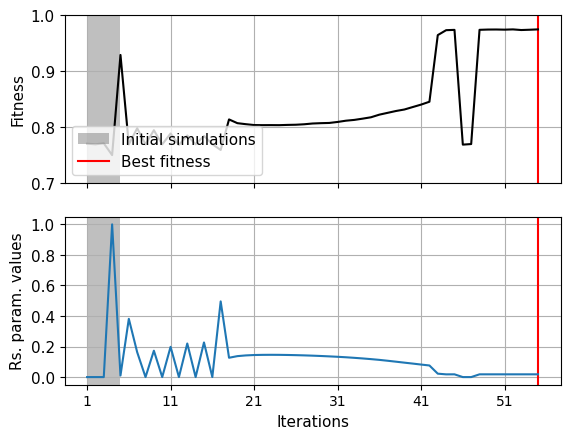

In [42]:
for index, row in df_t4.iterrows():
    fig1=plt.figure(figsize=(6,3))
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    #ax1 = fig1.add_subplot(111)
    fitness_range_l=0.7
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=10
    init_sim_range=5
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1)
    fitnes_range=np.round(np.linspace(fitness_range_l,fitness_range_h,fitness_range_step),1)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    #ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower left",prop={'size': 11})
    ax1.grid()
    
    
    #for j in range(len(row["x train rs"][0])):
       # param_name=row["Param names in set"][j]
       # ax2.errorbar(iterations_l,[sublist[j] for sublist in row["x train rs"]],label=param_name)

    for j in range(len(row["x train rs"][0])):
        param_name=row["Param names in set"][j]
        param_sel=[sublist[j] for sublist in row["x train rs"]]
        scaler_param_sel=MinMaxScaler2()
        param_sel_range=df_var_params_4[df_var_params_4["Param names"]==param_name]["Param values"].to_numpy()[0]
        scaler_param_sel.fit(param_sel_range)
        param_sel_rs=scaler_param_sel.transform(param_sel)
        ax2.errorbar(iterations_l,param_sel_rs,label=param_name)
        
    ax2.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax2.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax2.set_xlabel("Iterations",fontsize=11)
    ax2.set_ylabel("Rs. param. values",fontsize=11)
    #plt.ylim(10**-22,0.1*10**-18)
    ax2.set_yticks(param_value_range,param_value_range,fontsize=11)
    #ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    #ax2.legend(loc="lower left",prop={'size': 11})
    ax2.grid()
    
    #Grafik als PNG speichern
    #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
    #filename = f"{output_dir}/sim_la_opt_1_fitness.png"
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    
    plt.show()

    

Base angle


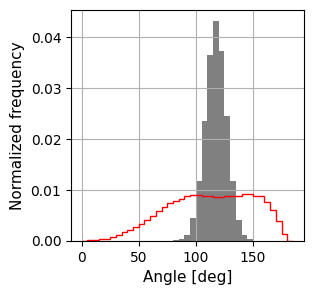

###########################
###########################
###########################
Link angle


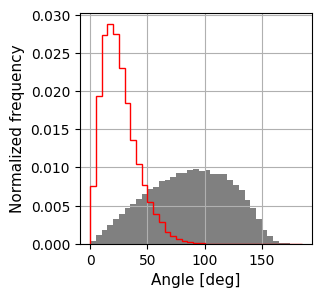

###########################
###########################
###########################
Arm axis angle


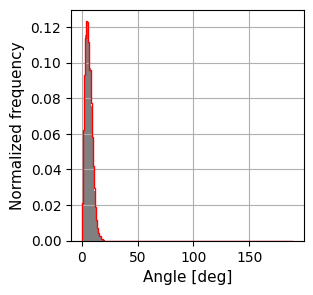

###########################
###########################
###########################
Base angle


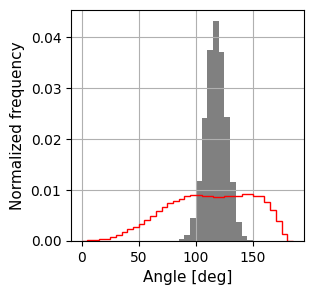

###########################
###########################
###########################
Link angle


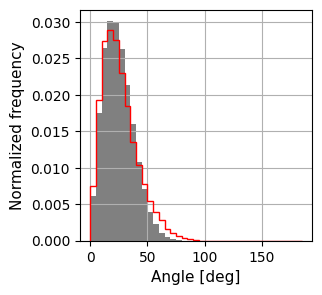

###########################
###########################
###########################
Arm axis angle


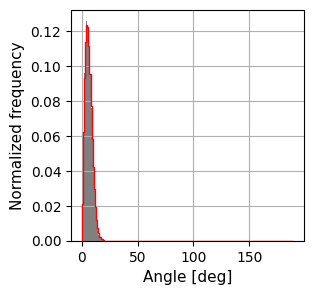

###########################
###########################
###########################
CPU times: user 1.66 s, sys: 2.93 s, total: 4.58 s
Wall time: 5.89 s


In [43]:
%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_la_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]] 

names_angles=["Base angle", "Link angle","Arm axis angle"]
for i in range(len(names_angle_eval)):
    n1,n2,n3,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1=cg_angle_distr_1_3_ba_aa_la(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    list_angles_eval=[values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1]
    
    for j in range(len(list_angles_eval)):
        fig1=plt.figure(figsize=(3,3))
        ax1 = fig1.add_subplot(111)
        if names_angles[j]=="Arm axis angle":
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='bar',color="grey")[0]
          
        else:
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
        print(names_angles[j])
        ax1.set_ylabel("Normalized frequency",fontsize=11)
        ax1.set_xlabel("Angle [deg]",fontsize=11)
        ax1.grid()
        
        #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
        #angle_name = names_angles[j].lower().replace(" ", "_") 
        #filename = f"{output_dir}/{names_ini1}angle_dist_{i}_{angle_name}.png"

        #plt.savefig(filename, dpi=300, bbox_inches='tight')
            
        plt.show()
  
        print("###########################")
        print("###########################")
        print("###########################")



In [44]:
folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_la_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

for i in range(len(names_angle_eval)):
    n1, n2, n3, values_angle_base_ex_1, values_angle_link_ex_1, values_angle_arm_axis_ex_1 = cg_angle_distr_1_3_ba_aa_la(
        folder=folder_names_angle_eval,
        names_sim_repeat=names_angle_eval[i],
        t_skip=300,
        t_lim=None,
        t_step=1
    )

    # Link angle analysieren (Radiant -> Grad)
    link_angles_sim = values_angle_link_ex_1 * 180 / np.pi
    link_angles_target = list_values_target_angles_1[1] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(link_angles_sim, link_angles_target)
    print(f"Datensatz {i+1}:")
    print(f"  Kolmogorov-Smirnov-Test (Link angle): Statistik={ks_stat:.4f}, p-Wert={ks_p:.4e}")

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(link_angles_sim, link_angles_target)
    print(f"  Wasserstein-Distanz (Link angle): {wass_dist:.4f} Grad\n")

Datensatz 1:
  Kolmogorov-Smirnov-Test (Link angle): Statistik=0.7447, p-Wert=0.0000e+00
  Wasserstein-Distanz (Link angle): 60.9757 Grad

Datensatz 2:
  Kolmogorov-Smirnov-Test (Link angle): Statistik=0.0434, p-Wert=1.5824e-42
  Wasserstein-Distanz (Link angle): 1.6018 Grad



## Angle between bound arms

In [45]:
#copy of sim params
run_sim_1_input_5=run_sim_1_input.copy()

#update parameters optimized in previous step
#run_sim_1_input_5.update(dict_opt_params_step_1)
#run_sim_1_input_5.update(dict_opt_params_step_2)
#run_sim_1_input_5.update(dict_opt_params_step_3)
#run_sim_1_input_5.update(dict_opt_params_step_4)

#load state with two fused motifs
run_sim_1_input_5["checkpoint_path"]="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/checkpoint_bm/"

#specify which parameters are to be optimised over which range
var_params_5={"Param names":["k_angle_ds_fused_link"],
                         
            "Param values":[k_angle_ds_fused_link_range],
            
            "Set of indep params":[0],
           "Index init guess":[[0,3]] #[1,8]
           }


df_var_params_5=pd.DataFrame(var_params_5)

#placeholder scaler on real values
df_var_params_5 = rescaled_params_no_sc_df(df_var_params_5)

df_var_params_5

Param names                  Param values  Set of indep params  \
0  k_angle_ds_fused_link  [1e-24, 1e-22, 1e-20, 1e-18]                    0   

  Index init guess                Scalers               Rs param values  
0           [0, 3]  FunctionTransformer()  [1e-24, 1e-22, 1e-20, 1e-18]

In [46]:
#specify evaluation and Bayesian opt parameters for each independent set of parameters
#every independent parameter set needs own dictionaries for GP and eval, as parameters need to be updated independently later
GP_params_5={"x_rs":[[0]],"x_train_rs":[[0]],"x":[[0]],"f_train_rs":[[0]],"seed":1,"dim_x":1,"dim_y":1,"num_restarts":100,"raw_samples":1000,"scaler_x":MinMaxScaler2}


Eval_params_5={"folder":None,"names_sim_repeat":None,"t_skip":300,"t_lim":None,"t_step":1,
             "angle_ds_fused_link_distr_target":angle_ds_fused_link_distr_target}

eval_opt_param_set_5={"Set of indep params":[0],
                      "Eval fct": [eval_sim_1_1_bm],
                      "Eval params":[Eval_params_5],
                      "Scaler": [StandardScaler()],
                      "GP": [apply_gp_bo_1],
                      "GP params": [GP_params_5]}

df_eval_opt_param_set_5=pd.DataFrame(eval_opt_param_set_5)
df_eval_opt_param_set_5

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_bm at 0x70a4e6caea60>   

                                         Eval params            Scaler  \
0  {'folder': None, 'names_sim_repeat': None, 't_...  StandardScaler()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x70a600f89f70>   

                                           GP params  
0  {'x_rs': [[0]], 'x_train_rs': [[0]], 'x': [[0]...

In [ ]:
#run optimization
df_t5,gpr_5=run_gp_11(df_run_sim=run_sim_1_input_5,
              df_var_params=df_var_params_5,
              fct_sim=run_sim_1,
              df_eval_opt_param_set=df_eval_opt_param_set_5,
              sim_folder="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/",
              sim_name="sim_bm_opt_2_",
              file_name_sim_params=None, #"params_bm_opt_1", 
              sim_repeats=5,
              iterations=50,
              print_sim_config=False,
              load_existing_init_sims=True,
              load_existing_opt_sims=True)

Step  1 / 2  initial simulations
y_centre_1 #
y_base_arm_a_1 #
y_arm_a_1 #
y_link_a_1 #
y_base_arm_b_1 #y_centre_1
 y_arm_b_1# 
#y_base_arm_a_1
 y_link_fused_b_1# 
#y_arm_a_1
 y_base_arm_c_1# 
#y_centre_1y_link_a_1
  y_arm_c_1## 

#y_base_arm_b_1y_base_arm_a_1
  y_link_c_1## 

#y_arm_b_1y_arm_a_1
  y_centre_1## 

y_link_fused_b_1#y_link_a_1 
 #y_base_arm_a_1# 

#y_base_arm_c_1y_base_arm_b_1
 y_arm_a_1#  #
y_arm_c_1#
 
y_arm_b_1y_link_a_1# 
 ##y_link_c_1

 y_link_fused_b_1y_base_arm_b_1#  
##y_centre_1

 y_base_arm_c_1y_centre_1y_arm_b_1#   
###y_base_arm_a_1


 y_arm_c_1y_base_arm_a_1y_link_b_1#   #
#
y_arm_a_1#
y_link_c_1 
y_arm_a_1 #y_base_arm_c_1 #
 #
y_link_a_1#
y_centre_1 
y_link_a_1y_centre_1 #y_arm_c_1# 
  #
#y_base_arm_b_1#
y_base_arm_a_1
 
y_base_arm_b_1 y_base_arm_a_1# y_link_fused_c_1#
 # 
#y_arm_b_1
#y_arm_a_1
 y_arm_b_1
 y_arm_a_1##  

#y_link_b_1#y_link_a_1
 
 y_link_a_1#y_link_fused_b_1# 
 
#y_base_arm_c_1#
y_base_arm_b_1 
 y_base_arm_b_1#y_base_arm_c_1 #
 #
y_arm_c_1#
y

In [48]:
#create dictionary with updated parameters
dict_opt_params_step_5={}
dict_opt_rs_params_step_5={}

for index, row in df_t5.iterrows():
    id_max=np.argmax(row["f train"])
    print("max fitness:",id_max,np.max(row["f train"]))
    opt_params_names=row["Param names in set"]
    opt_params_names_rs=[ e+"_rs" for e in opt_params_names]
    opt_params=row["x train"][id_max]
    opt_params_rs=row["x train rs"][id_max]
    
    for key, value in zip(opt_params_names,opt_params):
        dict_opt_params_step_5[key] = value
    for key, value in zip(opt_params_names_rs,opt_params_rs):
        dict_opt_rs_params_step_5[key] = value    
        
    print("param set:",row["Set of indep params"],row["x train rs"][id_max])
    print("param set:",row["Set of indep params"],row["x train"][id_max])

    
print(dict_opt_rs_params_step_5)    
print(dict_opt_params_step_5)

max fitness: 24 0.9941434987456156
param set: 0 [4.1661117228948155e-20]
param set: 0 [4.1661117228948155e-20]
{'k_angle_ds_fused_link_rs': 4.1661117228948155e-20}
{'k_angle_ds_fused_link': 4.1661117228948155e-20}


Parameter set 0


<Figure size 600x300 with 0 Axes>

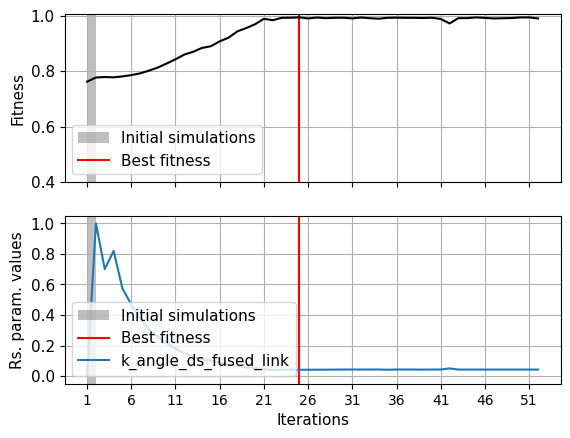

In [49]:
for index, row in df_t5.iterrows():
    fig1=plt.figure(figsize=(6,3))
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    #ax1 = fig1.add_subplot(111)
    fitness_range_l=0.4
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=5
    init_sim_range=2
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1) 
    fitnes_range=np.linspace(fitness_range_l,fitness_range_h,fitness_range_step)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    #ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower left",prop={'size': 11})
    ax1.grid()
    
    
    #for j in range(len(row["x train"][0])):
      #  param_name=row["Param names in set"][j]
       # ax2.errorbar(iterations_l,[sublist[j] for sublist in row["x train"]],label=param_name)
    
    for j in range(len(row["x train rs"][0])):
        param_name=row["Param names in set"][j]
        param_sel=[sublist[j] for sublist in row["x train rs"]]
        scaler_param_sel=MinMaxScaler2()
        param_sel_range=df_var_params_5[df_var_params_5["Param names"]==param_name]["Param values"].to_numpy()[0]
        scaler_param_sel.fit(param_sel_range)
        param_sel_rs=scaler_param_sel.transform(param_sel)
        ax2.errorbar(iterations_l,param_sel_rs,label=param_name)
        
    ax2.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax2.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax2.set_xlabel("Iterations",fontsize=11)
    ax2.set_ylabel("Rs. param. values",fontsize=11)
    ax2.set_yticks(param_value_range,param_value_range,fontsize=11)
    #ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    ax2.legend(loc="lower left",prop={'size': 11})
    ax2.grid()
    
    #Grafik als PNG speichern
    #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
    #filename = f"{output_dir}/sim_bm_opt_1_fitness.png"
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    
    plt.show()

    

y_centre_1 #
y_base_arm_a_1 y_centre_1#
 y_arm_a_1# 
#y_base_arm_a_1
 y_link_a_1# 
#y_arm_a_1
 y_base_arm_b_1#
 y_link_a_1#
 #y_arm_b_1 
#y_base_arm_b_1 
#y_link_fused_b_1
 y_arm_b_1# 
#y_base_arm_c_1
 y_centre_1y_link_fused_b_1#  
#y_arm_c_1#
 
y_base_arm_c_1#y_base_arm_a_1 
 #y_link_c_1#
 
y_arm_c_1#y_arm_a_1 
# y_centre_1
# y_link_c_1
# y_link_a_1
# y_base_arm_a_1
y_centre_1#y_centre_1 
  #y_base_arm_b_1##
 

y_arm_a_1#y_base_arm_a_1y_base_arm_a_1 
  #y_arm_b_1#
# 
y_link_a_1
#y_arm_a_1 y_arm_a_1
#  y_link_fused_b_1
## y_base_arm_b_1

# y_link_a_1y_link_a_1
#  y_base_arm_c_1
## y_arm_b_1

#y_base_arm_b_1 y_base_arm_b_1
 # y_arm_c_1#
# 
y_link_b_1
#y_arm_b_1y_arm_b_1 
  #y_link_c_1##

 y_centre_1
#y_link_b_1y_base_arm_c_1y_link_fused_b_1  
  ##y_centre_1##
 


y_base_arm_a_1#y_base_arm_c_1y_arm_c_1y_base_arm_c_1 
   ##y_base_arm_a_1##
 


y_arm_a_1#y_arm_c_1y_link_fused_c_1y_arm_c_1 
   y_arm_a_1####
 


y_link_a_1#y_link_fused_c_1y_link_c_1 
  ##y_link_a_1#


 y_base_arm_b_1#y_centr

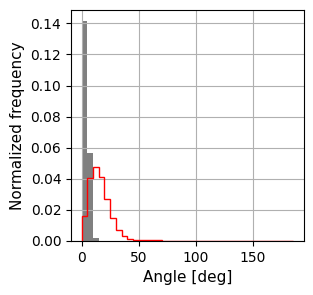

###########################
###########################
###########################
y_centre_1 #
y_base_arm_a_1 y_centre_1# 
#y_arm_a_1
 y_base_arm_a_1# 
#
y_link_a_1 y_arm_a_1 #
#y_base_arm_b_1
 y_link_a_1# 
#y_arm_b_1
y_base_arm_b_1 #y_centre_1 
# y_link_fused_b_1
# y_arm_b_1
# y_base_arm_a_1
 #y_base_arm_c_1#
 y_link_fused_b_1
# y_arm_a_1
# y_arm_c_1
# y_base_arm_c_1
# y_link_a_1
# y_link_c_1
#y_arm_c_1 
 #y_base_arm_b_1#
 y_centre_1
y_centre_1#y_link_c_1  
 #y_arm_b_1##
 

y_base_arm_a_1#y_base_arm_a_1y_centre_1 
  #y_link_fused_b_1##
 

y_arm_a_1#y_arm_a_1y_base_arm_a_1 
  #y_base_arm_c_1##
 

y_link_a_1#y_link_a_1y_arm_a_1 
  #y_arm_c_1##
 

y_base_arm_b_1#y_base_arm_b_1y_link_a_1 
  y_centre_1y_link_c_1###  


##y_arm_b_1y_arm_b_1y_base_arm_b_1

   y_centre_1y_base_arm_a_1###  


##y_link_fused_b_1y_arm_b_1y_link_b_1

   y_base_arm_a_1y_arm_a_1###  


##y_base_arm_c_1y_link_b_1y_base_arm_c_1

   y_arm_a_1y_link_a_1###  


##y_arm_c_1y_base_arm_c_1y_arm_c_1

   y_link_a_1y_base_a

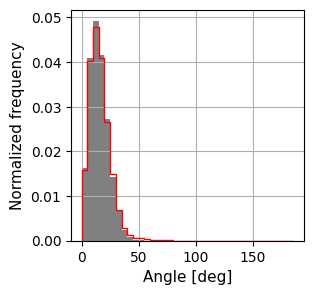

###########################
###########################
###########################
CPU times: user 928 ms, sys: 2.29 s, total: 3.22 s
Wall time: 1.91 s


In [50]:
%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_bm_opt_2_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

names_angles="Bound motifs angle"
for i in range(len(names_angle_eval)):
    angle_ds_fused_link_distr_ex_1, values_angle_ds_fused_link_ex1=cg_angle_distr_1_1_bm(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    
    fig1=plt.figure(figsize=(3,3))
    ax1 = fig1.add_subplot(111)

    sel_target_angle_distr=ax1.hist(list_values_target_angles_1[4]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
    sel_angle_distr=ax1.hist(values_angle_ds_fused_link_ex1*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
    print(names_angles)
    ax1.set_ylabel("Normalized frequency",fontsize=11)
    ax1.set_xlabel("Angle [deg]",fontsize=11)
    ax1.grid()
    
    #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
    #angle_name = names_angles[j].lower().replace(" ", "_") 
    #filename = f"{output_dir}/{names_ini1}angle_dist_{i}_{angle_name}.png"

    #plt.savefig(filename, dpi=300, bbox_inches='tight')
            
    plt.show()
  
    print("###########################")
    print("###########################")
    print("###########################")



In [51]:
folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_bm_opt_2_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

names_angles="Bound motifs angle"
for i in range(len(names_angle_eval)):
    angle_ds_fused_link_distr_ex_1, values_angle_ds_fused_link_ex1=cg_angle_distr_1_1_bm(
        folder=folder_names_angle_eval,
        names_sim_repeat=names_angle_eval[i],
        t_skip=300,
        t_lim=None,
        t_step=1
    )

    # Bound angle analysieren (Radiant -> Grad)
    bound_angles_sim = values_angle_ds_fused_link_ex1 * 180 / np.pi
    bound_angles_target = list_values_target_angles_1[4] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(bound_angles_sim, bound_angles_target)
    print(f"Datensatz {i+1}:")
    print(f"  Kolmogorov-Smirnov-Test (Bound angle): Statistik={ks_stat:.4f}, p-Wert={ks_p:.4e}")

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(bound_angles_sim, bound_angles_target)
    print(f"  Wasserstein-Distanz (Bound angle): {wass_dist:.4f} Grad\n")
    

y_centre_1 #y_centre_1
y_base_arm_a_1  ##

y_base_arm_a_1y_arm_a_1  ##

y_arm_a_1y_link_a_1  ##

y_link_a_1y_base_arm_b_1 y_centre_1 ## 

#y_base_arm_b_1y_arm_b_1
  #y_base_arm_a_1#y_centre_1
 
y_arm_b_1 #y_link_fused_b_1 #
 #
y_arm_a_1#
y_base_arm_a_1 
y_link_fused_b_1 # y_base_arm_c_1#
# 
y_link_a_1
# y_arm_a_1y_base_arm_c_1
 # y_arm_c_1#
# 
y_base_arm_b_1
#y_link_a_1 y_arm_c_1
 # #y_link_c_1
# 
y_arm_b_1
#y_base_arm_b_1y_link_c_1  
 ##y_centre_1#

 y_link_fused_b_1
y_centre_1#y_arm_b_1 y_centre_1
  # y_base_arm_a_1##
#
y_base_arm_c_1 
y_base_arm_a_1
 #y_base_arm_a_1y_link_fused_b_1 #
  #
y_arm_a_1##
y_arm_c_1 
y_arm_a_1
 #y_arm_a_1 #y_base_arm_c_1
 #
 y_link_a_1#y_link_c_1
# 
 
#y_link_a_1y_link_a_1#y_arm_c_1  

 #y_base_arm_b_1#y_centre_1#
  

y_base_arm_b_1##y_base_arm_b_1y_link_c_1 

  #y_arm_b_1y_base_arm_a_1##
  

y_arm_b_1##y_arm_b_1y_centre_1 

 # y_link_b_1y_arm_a_1##
  

y_link_fused_b_1##y_link_b_1y_base_arm_a_1 

  #y_base_arm_c_1y_link_a_1##
 
 y_base_arm_c_1
#y_base_arm

## Base + arm axis angle

In [73]:
#copy of sim params
run_sim_1_input_6=run_sim_1_input.copy()

#update parameters optimized in previous step
#run_sim_1_input_6.update(dict_opt_params_step_1)

#specify which parameters are to be optimised over which range
var_params_6={"Param names":["k_angle_ds_base",
                             "theta_base_x",
                             "k_angle_ds_arm"
                            ],
                         
            "Param values":[k_angle_ds_base_range,                           
                            theta_base_x_range,
                            k_angle_ds_arm_range,
                           ],
            
            "Set of indep params":[0,     
                                   0,
                                   1,
                                  ],
           "Index init guess":[[0,0,3,3,2],
                               [0,3,0,3,2],
                               [0,0,0,3,2]
                              ]
           }


df_var_params_6=pd.DataFrame(var_params_6)

#placeholder scaler on real values
df_var_params_6 = rescaled_params_no_sc_df(df_var_params_6)


df_var_params_6

Param names                                       Param values  \
0  k_angle_ds_base                       [1e-24, 1e-22, 1e-20, 1e-18]   
1     theta_base_x  [1.5707963267948966, 2.0943951023931953, 2.617...   
2   k_angle_ds_arm                       [1e-24, 1e-22, 1e-20, 1e-18]   

   Set of indep params Index init guess                Scalers  \
0                    0  [0, 0, 3, 3, 2]  FunctionTransformer()   
1                    0  [0, 3, 0, 3, 2]  FunctionTransformer()   
2                    1  [0, 0, 0, 3, 2]  FunctionTransformer()   

                                     Rs param values  
0                       [1e-24, 1e-22, 1e-20, 1e-18]  
1  [1.5707963267948966, 2.0943951023931953, 2.617...  
2                       [1e-24, 1e-22, 1e-20, 1e-18]

In [74]:
#specify evaluation and Bayesian opt parameters for each independent set of parameters
#every independent parameter set needs own dictionaries for GP and eval, as parameters need to be updated independently later
GP_params_6_0={"x_rs":[[0]],"x_train_rs":[[0]],"x":[[0]],"f_train_rs":[[0]],"seed":1,"dim_x":2,"dim_y":1,"num_restarts":1000,"raw_samples":10000,"scaler_x":MinMaxScaler2}
GP_params_6_1={"x_rs":[[0]],"x_train_rs":[[0]],"x":[[0]],"f_train_rs":[[0]],"seed":1,"dim_x":1,"dim_y":1,"num_restarts":1000,"raw_samples":10000,"scaler_x":MinMaxScaler2}


Eval_params_6_0={"folder":None,"names_sim_repeat":None,"t_skip":300,"t_lim":None,"t_step":1,
             "base_angle_distr_target":base_angle_distr_target}

Eval_params_6_1={"folder":None,"names_sim_repeat":None,"t_skip":300,"t_lim":None,"t_step":1,
             "arm_axis_angle_distr_target":arm_axis_angle_distr_target}

eval_opt_param_set_6={"Set of indep params":[0,
                                             1],
                      "Eval fct": [eval_sim_1_1_ba,
                                   eval_sim_1_1_aa],
                      "Eval params":[Eval_params_6_0,
                                     Eval_params_6_1],
                      "Scaler": [FunctionTransformer(func=None),
                                 FunctionTransformer(func=None)],
                      "GP": [apply_gp_bo_1,
                             apply_gp_bo_1],
                      "GP params": [GP_params_6_0,
                                    GP_params_6_1]}

df_eval_opt_param_set_6=pd.DataFrame(eval_opt_param_set_6)
df_eval_opt_param_set_6

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_ba at 0x707775927940>   
1                    1  <function eval_sim_1_1_aa at 0x707775927a60>   

                                         Eval params                 Scaler  \
0  {'folder': None, 'names_sim_repeat': None, 't_...  FunctionTransformer()   
1  {'folder': None, 'names_sim_repeat': None, 't_...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x7078983c35e0>   
1  <function apply_gp_bo_1 at 0x7078983c35e0>   

                                           GP params  
0  {'x_rs': [[0]], 'x_train_rs': [[0]], 'x': [[0]...  
1  {'x_rs': [[0]], 'x_train_rs': [[0]], 'x': [[0]...

In [75]:
%%time
#run optimization
df_t6,gpr_6=run_gp_11(df_run_sim=run_sim_1_input_6,
              df_var_params=df_var_params_6,
              fct_sim=run_sim_1,
              df_eval_opt_param_set=df_eval_opt_param_set_6,
              sim_folder="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/",
              sim_name="sim_ba_aa_seq_opt_1_",
              file_name_sim_params=None, #"params_ba_aa_opt_1", 
              sim_repeats=5,
              iterations=50,
              print_sim_config=False,
              load_existing_init_sims=True,
              load_existing_opt_sims=True)

Step  1 / 5  initial simulations
Step  2 / 5  initial simulations
Step  3 / 5  initial simulations
Step  4 / 5  initial simulations
Step  5 / 5  initial simulations
Step  1 / 50  optimization simulations
[0.20374661 0.46356874] [2.03747411e-19 2.29896840e+00]
[0.28631007] [2.86310787e-19]
Step  2 / 50  optimization simulations
[0.         0.79265611] [1.00000000e-24 2.81589763e+00]
[0.53970894] [5.39709401e-19]
Step  3 / 50  optimization simulations
[0.         0.42913968] [1.00000000e-24 2.24488736e+00]
[0.37655585] [3.76556478e-19]
Step  4 / 50  optimization simulations
[0.86431384 0.        ] [8.64313975e-19 1.57079633e+00]
[0.35758382] [3.57584464e-19]
Step  5 / 50  optimization simulations
[0.05135034 0.6805258 ] [5.13512870e-20 2.63976375e+00]
[0.33434594] [3.34346608e-19]
Step  6 / 50  optimization simulations
[0.        0.6075134] [1.00000000e-24 2.52507614e+00]
[0.34436676] [3.4436742e-19]
Step  7 / 50  optimization simulations
[1. 0.] [1.00000000e-18 1.57079633e+00]
[0.344067

/home/xenia/anaconda3/envs/readdy2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/home/xenia/anaconda3/envs/readdy2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/home/xenia/anaconda3/envs/readdy2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/xenia/anaconda3/envs/readdy2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/xenia/anaconda3/envs/readdy2/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/home/xenia/anaconda3/envs/readdy2/lib/python3.9/site-packag

[0.         0.78198439] [1.00000000e-24 2.79913453e+00]
[0.3405444] [3.40545055e-19]
Step  24 / 50  optimization simulations
[0.         0.77439348] [1.00000000e-24 2.78721076e+00]
[0.33904695] [3.39047611e-19]
Step  25 / 50  optimization simulations
[0.         0.63724412] [1.00000000e-24 2.57177706e+00]
[0.34049919] [3.40499853e-19]
Step  26 / 50  optimization simulations
[0.         0.73442016] [1.00000000e-24 2.72442082e+00]
[0.33942205] [3.39422712e-19]
Step  27 / 50  optimization simulations
[0.00907103 0.53539307] [9.07201748e-21 2.41178979e+00]
[0.34047517] [3.40475826e-19]
Step  28 / 50  optimization simulations
[0.         0.85209552] [1.00000000e-24 2.90926483e+00]
[0.34056486] [3.40565523e-19]
Step  29 / 50  optimization simulations
[0.         0.25020636] [1.00000000e-24 1.96381956e+00]
[0.3427091] [3.42709753e-19]
Step  30 / 50  optimization simulations
[0.         0.70239834] [1.00000000e-24 2.67412106e+00]
[0.34263603] [3.42636691e-19]
Step  31 / 50  optimization simula

In [76]:
df_t6

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_ba at 0x707775927940>   
1                    1  <function eval_sim_1_1_aa at 0x707775927a60>   

                                         Eval params                 Scaler  \
0  {'folder': '/home/xenia/Masterthesis_ReaDDy/Ba...  FunctionTransformer()   
1  {'folder': '/home/xenia/Masterthesis_ReaDDy/Ba...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x7078983c35e0>   
1  <function apply_gp_bo_1 at 0x7078983c35e0>   

                                           GP params  \
0  {'x_rs': [[1e-24, 1.5707963267948966], [1e-24,...   
1  {'x_rs': [[1e-24], [1e-22], [1e-20], [1e-18]],...   

                Param names in set  \
0  [k_angle_ds_base, theta_base_x]   
1                 [k_angle_ds_arm]   

                                             f train  \
0  [0.9110681914120655, 0.9182052120921282, 0.927...   
1  [0.3392769511550054, 0.33904204797216053, 0.33...   

                                          f train rs  \
0  [0.9110681914120655, 0.9182052120921282, 0.927...   
1  [0.3392769511550054, 0.33904204797216053, 0.33...   

                                          x train rs  \
0  [[1e-24, 1.5707963267948966], [1e-24, 3.141592...   
1  [[1e-24], [1e-24], [1e-24], [1e-18], [1e-20], ...   

                                             x train  
0  [[1e-24, 1.5707963267948966], [1e-24, 3.141592...  
1  [[1e-24], [1e-24], [1e-24], [1e-18], [1e-20], ...

In [77]:
#create dictionary with updated parameters
dict_opt_params_step_6={}
dict_opt_rs_params_step_6={}

for index, row in df_t6.iterrows():
    id_max=np.argmax(row["f train"])
    print("max fitness:",id_max,np.max(row["f train"]))
    opt_params_names=row["Param names in set"]
    opt_params_names_rs=[ e+"_rs" for e in opt_params_names]
    opt_params=row["x train"][id_max]
    opt_params_rs=row["x train rs"][id_max]
    
    for key, value in zip(opt_params_names,opt_params):
        dict_opt_params_step_6[key] = value
    for key, value in zip(opt_params_names_rs,opt_params_rs):
        dict_opt_rs_params_step_6[key] = value    
        
    print("param set:",row["Set of indep params"],row["x train rs"][id_max])
    print("param set:",row["Set of indep params"],row["x train"][id_max])

    
print(dict_opt_rs_params_step_6)    
print(dict_opt_params_step_6)

max fitness: 4 0.9503153106646564
param set: 0 [1e-20, 2.6179938779914944]
param set: 0 [1e-20, 2.6179938779914944]
max fitness: 51 0.990635259540694
param set: 1 [3.399485124540198e-19]
param set: 1 [3.399485124540198e-19]
{'k_angle_ds_base_rs': 1e-20, 'theta_base_x_rs': 2.6179938779914944, 'k_angle_ds_arm_rs': 3.399485124540198e-19}
{'k_angle_ds_base': 1e-20, 'theta_base_x': 2.6179938779914944, 'k_angle_ds_arm': 3.399485124540198e-19}


Parameter set 0


<Figure size 600x300 with 0 Axes>

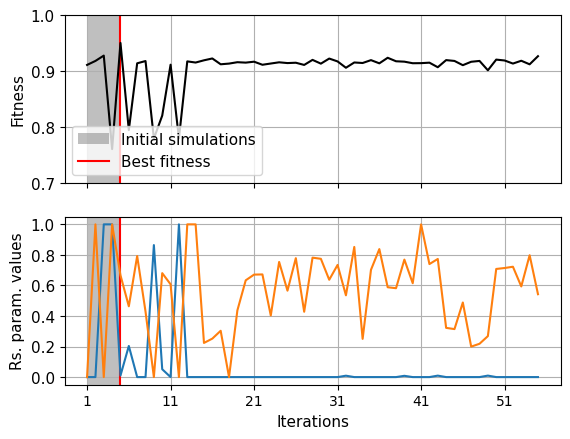

Parameter set 1


<Figure size 600x300 with 0 Axes>

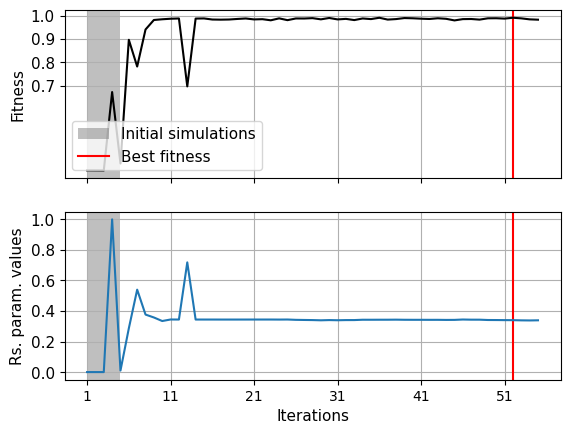

In [78]:
for index, row in df_t6.iterrows():
    fig1=plt.figure(figsize=(6,3))
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    #ax1 = fig1.add_subplot(111)
    fitness_range_l=0.7
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=10
    init_sim_range=5
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1)
    fitnes_range=np.round(np.linspace(fitness_range_l,fitness_range_h,fitness_range_step),1)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    #ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower left",prop={'size': 11})
    ax1.grid()
    
    for j in range(len(row["x train rs"][0])):
        param_name=row["Param names in set"][j]
        param_sel=[sublist[j] for sublist in row["x train rs"]]
        scaler_param_sel=MinMaxScaler2()
        param_sel_range=df_var_params_6[df_var_params_6["Param names"]==param_name]["Param values"].to_numpy()[0]
        scaler_param_sel.fit(param_sel_range)
        param_sel_rs=scaler_param_sel.transform(param_sel)
        ax2.errorbar(iterations_l,param_sel_rs,label=param_name)
        
    ax2.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax2.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax2.set_xlabel("Iterations",fontsize=11)
    ax2.set_ylabel("Rs. param. values",fontsize=11)
    #plt.ylim(10**-22,0.1*10**-18)
    ax2.set_yticks(param_value_range,param_value_range,fontsize=11)
    #ax2.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))
    #ax2.legend(loc="lower left",prop={'size': 11})
    ax2.grid()
    
    #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
    #filename = f"{output_dir}/sim_ba_aa_seq_opt_1_fitness.png"
    #plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    
    plt.show()

    

Base angle


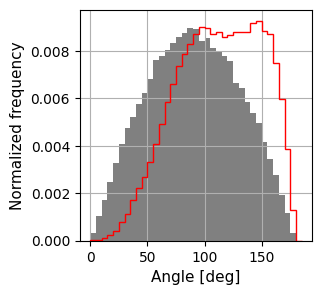

###########################
###########################
###########################
Link angle


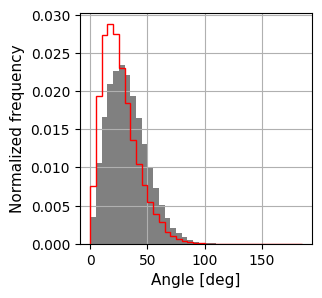

###########################
###########################
###########################
Arm axis angle


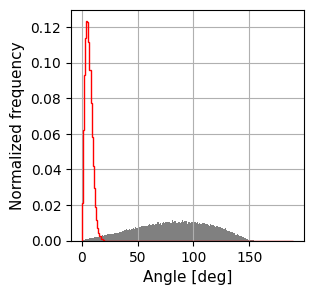

###########################
###########################
###########################
Base angle


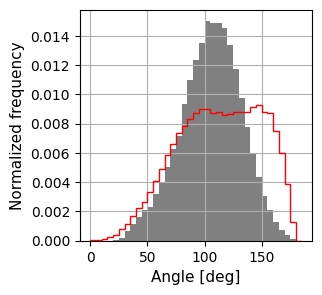

###########################
###########################
###########################
Link angle


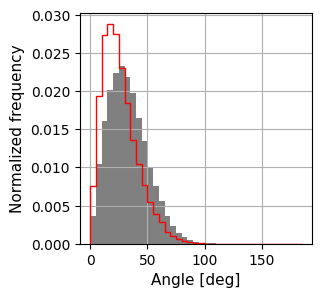

###########################
###########################
###########################
Arm axis angle


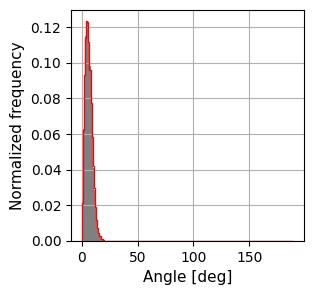

###########################
###########################
###########################
CPU times: user 1.45 s, sys: 2.94 s, total: 4.4 s
Wall time: 5.21 s


In [79]:
%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_ba_aa_seq_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+240)+".h5" for l in range(5)]] 

names_angles=["Base angle", "Link angle","Arm axis angle"]
for i in range(len(names_angle_eval)):
    n1,n2,n3,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1=cg_angle_distr_1_3_ba_aa_la(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    list_angles_eval=[values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1]
    
    for j in range(len(list_angles_eval)):
        fig1=plt.figure(figsize=(3,3))
        ax1 = fig1.add_subplot(111)
        if names_angles[j]=="Arm axis angle":
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='bar',color="grey")[0]
          
        else:
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
        print(names_angles[j])
        ax1.set_ylabel("Normalized frequency",fontsize=11)
        ax1.set_xlabel("Angle [deg]",fontsize=11)
        ax1.grid()
        
        #output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
        #angle_name = names_angles[j].lower().replace(" ", "_") 
        #filename = f"{output_dir}/{names_ini1}angle_dist_{i}_{angle_name}.png"

        #plt.savefig(filename, dpi=300, bbox_inches='tight')
            
        plt.show()
  
        print("###########################")
        print("###########################")
        print("###########################")



In [81]:
folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_ba_aa_seq_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+240)+".h5" for l in range(5)]] 

names_angles=["Base angle", "Link angle","Arm axis angle"]
for i in range(len(names_angle_eval)):
    n1,n2,n3,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1=cg_angle_distr_1_3_ba_aa_la(
        folder=folder_names_angle_eval,
        names_sim_repeat=names_angle_eval[i],
        t_skip=300,
        t_lim=None,t_step=1)
    
    

    # Base angle analysieren (Radiant -> Grad)
    base_angles_sim = values_angle_base_ex_1 * 180 / np.pi
    base_angles_target = list_values_target_angles_1[0] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(base_angles_sim, base_angles_target)
    print(f"Datensatz Base {i+1}:")
    print(f"  Kolmogorov-Smirnov-Test (Base angle): Statistik={ks_stat:.4f}, p-Wert={ks_p:.4e}")

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(base_angles_sim, base_angles_target)
    print(f"  Wasserstein-Distanz (Base angle): {wass_dist:.4f} Grad\n")

    # Arm axis angle analysieren (Radiant -> Grad)
    arm_axis_angles_sim = values_angle_arm_axis_ex_1 * 180 / np.pi
    arm_axis_angles_target = list_values_target_angles_1[2] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(arm_axis_angles_sim, arm_axis_angles_target)
    print(f"Datensatz Arm axis {i+1}:")
    print(f"  Kolmogorov-Smirnov-Test (Arm axis angle): Statistik={ks_stat:.4f}, p-Wert={ks_p:.4e}")

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(arm_axis_angles_sim, arm_axis_angles_target)
    print(f"  Wasserstein-Distanz (Arm axis angle): {wass_dist:.4f} Grad\n")

Datensatz Base 1:
  Kolmogorov-Smirnov-Test (Base angle): Statistik=0.2118, p-Wert=0.0000e+00
  Wasserstein-Distanz (Base angle): 22.0318 Grad

Datensatz Arm axis 1:
  Kolmogorov-Smirnov-Test (Arm axis angle): Statistik=0.9754, p-Wert=0.0000e+00
  Wasserstein-Distanz (Arm axis angle): 76.0445 Grad

Datensatz Base 2:
  Kolmogorov-Smirnov-Test (Base angle): Statistik=0.1881, p-Wert=0.0000e+00
  Wasserstein-Distanz (Base angle): 10.1915 Grad

Datensatz Arm axis 2:
  Kolmogorov-Smirnov-Test (Arm axis angle): Statistik=0.0055, p-Wert=1.1009e-01
  Wasserstein-Distanz (Arm axis angle): 0.0333 Grad



## AA, dann BA Opt

In [82]:
#copy of sim params
run_sim_1_input_7=run_sim_1_input.copy()



#specify which parameters are to be optimised over which range
var_params_7={"Param names":["k_angle_ds_arm"],
                         
            "Param values":[k_angle_ds_arm_range],
            
            "Set of indep params":[0],
           "Index init guess":[[0,3]] #[1,8]
           }

df_var_params_7=pd.DataFrame(var_params_7)



#placeholder scaler on real values
df_var_params_7 = rescaled_params_no_sc_df(df_var_params_7)


df_var_params_7

Param names                  Param values  Set of indep params  \
0  k_angle_ds_arm  [1e-24, 1e-22, 1e-20, 1e-18]                    0   

  Index init guess                Scalers               Rs param values  
0           [0, 3]  FunctionTransformer()  [1e-24, 1e-22, 1e-20, 1e-18]

In [83]:
#specify evaluation and Bayesian opt parameters for each independent set of parameters
#every independent parameter set needs own dictionaries for GP and eval, as parameters need to be updated independently later


GP_params_7={"x_rs":[[0]],"x_train_rs":[[0]],"x":[[0]],"f_train_rs":[[0]],"seed":1,"dim_x":1,"dim_y":1,"num_restarts":100,"raw_samples":1000,"scaler_x":MinMaxScaler2}


Eval_params_7={"folder":None,"names_sim_repeat":None,"t_skip":300,"t_lim":None,"t_step":1,
             "arm_axis_angle_distr_target":arm_axis_angle_distr_target}

eval_opt_param_set_7={"Set of indep params":[0],
                      "Eval fct": [eval_sim_1_1_aa],
                      "Eval params":[Eval_params_7],
                      "Scaler": [FunctionTransformer(func=None)],
                      "GP": [apply_gp_bo_1],
                      "GP params": [GP_params_7]}

df_eval_opt_param_set_7=pd.DataFrame(eval_opt_param_set_7)
df_eval_opt_param_set_7

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_aa at 0x707775927a60>   

                                         Eval params                 Scaler  \
0  {'folder': None, 'names_sim_repeat': None, 't_...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x7078983c35e0>   

                                           GP params  
0  {'x_rs': [[0]], 'x_train_rs': [[0]], 'x': [[0]...

In [84]:
%%time
#run optimization
df_t7,gpr_7=run_gp_11(df_run_sim=run_sim_1_input_7,
              df_var_params=df_var_params_7,
              fct_sim=run_sim_1,
              df_eval_opt_param_set=df_eval_opt_param_set_7,
              sim_folder="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/",
              sim_name="sim_aa_seq_opt_1_",
              file_name_sim_params=None, #"params_aa_opt_1", 
              sim_repeats=5,
              iterations=50,
              print_sim_config=False,
              load_existing_init_sims=True,
              load_existing_opt_sims=True)

Step  1 / 2  initial simulations
Step  2 / 2  initial simulations
Step  1 / 50  optimization simulations
[0.69999221] [6.99992515e-19]
Step  2 / 50  optimization simulations
[0.56644614] [5.66446569e-19]
Step  3 / 50  optimization simulations
[0.47979445] [4.79794974e-19]
Step  4 / 50  optimization simulations
[0.40040598] [4.0040658e-19]
Step  5 / 50  optimization simulations
[0.33059768] [3.30598346e-19]
Step  6 / 50  optimization simulations
[0.28158189] [2.81582604e-19]
Step  7 / 50  optimization simulations
[0.34658908] [3.46589732e-19]
Step  8 / 50  optimization simulations
[0.34105816] [3.41058819e-19]
Step  9 / 50  optimization simulations
[0.34101737] [3.41018027e-19]
Step  10 / 50  optimization simulations
[0.34141985] [3.41420511e-19]
Step  11 / 50  optimization simulations
[0.34239521] [3.42395866e-19]
Step  12 / 50  optimization simulations
[0.34264935] [3.42650011e-19]
Step  13 / 50  optimization simulations
[0.34185276] [3.41853418e-19]
Step  14 / 50  optimization simula

In [85]:
df_t7

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_aa at 0x707775927a60>   

                                         Eval params                 Scaler  \
0  {'folder': '/home/xenia/Masterthesis_ReaDDy/Ba...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x7078983c35e0>   

                                           GP params Param names in set  \
0  {'x_rs': [[1e-24], [1e-22], [1e-20], [1e-18]],...   [k_angle_ds_arm]   

                                             f train  \
0  [0.3390713930798871, 0.6354931403997908, 0.702...   

                                          f train rs  \
0  [0.3390713930798871, 0.6354931403997908, 0.702...   

                                          x train rs  \
0  [[1e-24], [1e-18], [6.999925146980174e-19], [5...   

                                             x train  
0  [[1e-24], [1e-18], [6.999925146980174e-19], [5...

In [86]:
#create dictionary with updated parameters
dict_opt_params_step_7={}
dict_opt_rs_params_step_7={}

for index, row in df_t7.iterrows():
    id_max=np.argmax(row["f train"])
    print("max fitness:",id_max,np.max(row["f train"]))
    opt_params_names=row["Param names in set"]
    opt_params_names_rs=[ e+"_rs" for e in opt_params_names]
    opt_params=row["x train"][id_max]
    opt_params_rs=row["x train rs"][id_max]
    
    for key, value in zip(opt_params_names,opt_params):
        dict_opt_params_step_7[key] = value
    for key, value in zip(opt_params_names_rs,opt_params_rs):
        dict_opt_rs_params_step_7[key] = value    
        
    print("param set:",row["Set of indep params"],row["x train rs"][id_max])
    print("param set:",row["Set of indep params"],row["x train"][id_max])

    
print(dict_opt_rs_params_step_7)    
print(dict_opt_params_step_7)

max fitness: 11 0.9915153411563633
param set: 0 [3.4142051091773254e-19]
param set: 0 [3.4142051091773254e-19]
{'k_angle_ds_arm_rs': 3.4142051091773254e-19}
{'k_angle_ds_arm': 3.4142051091773254e-19}


In [87]:
#copy of sim params
run_sim_1_input_8=run_sim_1_input.copy()

#update parameters optimized in previous step
run_sim_1_input_8.update(dict_opt_params_step_7)

#specify which parameters are to be optimised over which range
var_params_8={"Param names":["k_angle_ds_base",
                             "theta_base_x"],
                         
            "Param values":[k_angle_ds_base_range,                           
                            theta_base_x_range],
            
            "Set of indep params":[0,     
                                   0],
           "Index init guess":[[0,0,3,3,2], # nachfragen wie viele werte richtig
                               [0,3,0,3,2],
                              ]
           }

df_var_params_8=pd.DataFrame(var_params_8)

#placeholder scaler on real values
df_var_params_8 = rescaled_params_no_sc_df(df_var_params_8)


df_var_params_8

Param names                                       Param values  \
0  k_angle_ds_base                       [1e-24, 1e-22, 1e-20, 1e-18]   
1     theta_base_x  [1.5707963267948966, 2.0943951023931953, 2.617...   

   Set of indep params Index init guess                Scalers  \
0                    0  [0, 0, 3, 3, 2]  FunctionTransformer()   
1                    0  [0, 3, 0, 3, 2]  FunctionTransformer()   

                                     Rs param values  
0                       [1e-24, 1e-22, 1e-20, 1e-18]  
1  [1.5707963267948966, 2.0943951023931953, 2.617...

In [88]:
#specify evaluation and Bayesian opt parameters for each independent set of parameters
#every independent parameter set needs own dictionaries for GP and eval, as parameters need to be updated independently later
GP_params_8={"x_rs":[[0]],"x_train_rs":[[0]],"x":[[0]],"f_train_rs":[[0]],"seed":1,"dim_x":2,"dim_y":1,"num_restarts":1000,"raw_samples":10000,"scaler_x":MinMaxScaler2}


Eval_params_8={"folder":None,"names_sim_repeat":None,"t_skip":300,"t_lim":None,"t_step":1,
             "base_angle_distr_target":base_angle_distr_target}

eval_opt_param_set_8={"Set of indep params":[0],
                      "Eval fct": [eval_sim_1_1_ba],
                      "Eval params":[Eval_params_8],
                      "Scaler": [FunctionTransformer(func=None)],
                      "GP": [apply_gp_bo_1],
                      "GP params": [GP_params_8]}

df_eval_opt_param_set_8=pd.DataFrame(eval_opt_param_set_8)
df_eval_opt_param_set_8

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_ba at 0x707775927940>   

                                         Eval params                 Scaler  \
0  {'folder': None, 'names_sim_repeat': None, 't_...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x7078983c35e0>   

                                           GP params  
0  {'x_rs': [[0]], 'x_train_rs': [[0]], 'x': [[0]...

In [89]:
%%time
#run optimization
df_t8,gpr_8=run_gp_11(df_run_sim=run_sim_1_input_8,
              df_var_params=df_var_params_8,
              fct_sim=run_sim_1,
              df_eval_opt_param_set=df_eval_opt_param_set_8,
              sim_folder="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/",
              sim_name="sim_ba_seq_opt_1_",
              file_name_sim_params=None, #"params_ba_opt_1", 
              sim_repeats=5,
              iterations=50,
              print_sim_config=False,
              load_existing_init_sims=True,
              load_existing_opt_sims=True)

Step  1 / 5  initial simulations
Step  2 / 5  initial simulations
Step  3 / 5  initial simulations
Step  4 / 5  initial simulations
Step  5 / 5  initial simulations
Step  1 / 50  optimization simulations
[0.17730616 0.17676815] [1.77306986e-19 1.84846308e+00]
Step  2 / 50  optimization simulations
[0.         0.28493697] [1.00000000e-24 2.01837427e+00]
Step  3 / 50  optimization simulations
[0. 0.] [1.00000000e-24 1.57079633e+00]
Step  4 / 50  optimization simulations
[0.03601756 1.        ] [3.60185206e-20 3.14159265e+00]
Step  5 / 50  optimization simulations
[0.         0.72957122] [1.00000000e-24 2.71680412e+00]
Step  6 / 50  optimization simulations
[0.         0.65301841] [1.00000000e-24 2.59655524e+00]
Step  7 / 50  optimization simulations
[0.         0.80675377] [1.00000000e-24 2.83804219e+00]
Step  8 / 50  optimization simulations
[0. 0.] [1.00000000e-24 1.57079633e+00]
Step  9 / 50  optimization simulations
[0.         0.61920082] [1.0000000e-24 2.5434347e+00]
Step  10 / 50 

In [90]:
df_t8

Set of indep params                                      Eval fct  \
0                    0  <function eval_sim_1_1_ba at 0x707775927940>   

                                         Eval params                 Scaler  \
0  {'folder': '/home/xenia/Masterthesis_ReaDDy/Ba...  FunctionTransformer()   

                                           GP  \
0  <function apply_gp_bo_1 at 0x7078983c35e0>   

                                           GP params  \
0  {'x_rs': [[1e-24, 1.5707963267948966], [1e-24,...   

                Param names in set  \
0  [k_angle_ds_base, theta_base_x]   

                                             f train  \
0  [0.9137870160854615, 0.9091207212216318, 0.780...   

                                          f train rs  \
0  [0.9137870160854615, 0.9091207212216318, 0.780...   

                                          x train rs  \
0  [[1e-24, 1.5707963267948966], [1e-24, 3.141592...   

                                             x train  
0  [[1e-24, 1.5707963267948966], [1e-24, 3.141592...

In [91]:
#create dictionary with updated parameters
dict_opt_params_step_8={}
dict_opt_rs_params_step_8={}

for index, row in df_t8.iterrows():
    id_max=np.argmax(row["f train"])
    print("max fitness:",id_max,np.max(row["f train"]))
    opt_params_names=row["Param names in set"]
    opt_params_names_rs=[ e+"_rs" for e in opt_params_names]
    opt_params=row["x train"][id_max]
    opt_params_rs=row["x train rs"][id_max]
    
    for key, value in zip(opt_params_names,opt_params):
        dict_opt_params_step_8[key] = value
    for key, value in zip(opt_params_names_rs,opt_params_rs):
        dict_opt_rs_params_step_8[key] = value    
        
    print("param set:",row["Set of indep params"],row["x train rs"][id_max])
    print("param set:",row["Set of indep params"],row["x train"][id_max])

    
print(dict_opt_rs_params_step_8)    
print(dict_opt_params_step_8)

max fitness: 9 0.9241832460741681
param set: 0 [1e-24, 2.7168041161178205]
param set: 0 [1e-24, 2.7168041161178205]
{'k_angle_ds_base_rs': 1e-24, 'theta_base_x_rs': 2.7168041161178205}
{'k_angle_ds_base': 1e-24, 'theta_base_x': 2.7168041161178205}


In [92]:
folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_ba_seq_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

for i in range(len(names_angle_eval)):
    n1, n2, n3, values_angle_base_ex_1, values_angle_link_ex_1, values_angle_arm_axis_ex_1 = cg_angle_distr_1_3_ba_aa_la(
        folder=folder_names_angle_eval,
        names_sim_repeat=names_angle_eval[i],
        t_skip=300,
        t_lim=None,
        t_step=1
    )

    # Base angle analysieren (Radiant -> Grad)
    base_angles_sim = values_angle_base_ex_1 * 180 / np.pi
    base_angles_target = list_values_target_angles_1[0] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(base_angles_sim, base_angles_target)
    print(f"Datensatz {i+1}:")
    print(f"  Kolmogorov-Smirnov-Test (Base angle): Statistik={ks_stat:.4f}, p-Wert={ks_p:.4e}")

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(base_angles_sim, base_angles_target)
    print(f"  Wasserstein-Distanz (Base angle): {wass_dist:.4f} Grad\n")

Datensatz 1:
  Kolmogorov-Smirnov-Test (Base angle): Statistik=0.2956, p-Wert=0.0000e+00
  Wasserstein-Distanz (Base angle): 18.3635 Grad

Datensatz 2:
  Kolmogorov-Smirnov-Test (Base angle): Statistik=0.2431, p-Wert=0.0000e+00
  Wasserstein-Distanz (Base angle): 21.0850 Grad



In [93]:
folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"

names_ini1="sim_aa_seq_opt_1_"
names_angle_eval=[[names_ini1+str(l+10)+".h5" for l in range(5)],
                  [names_ini1+str(l+245)+".h5" for l in range(5)]]

for i in range(len(names_angle_eval)):
    n1, n2, n3, values_angle_base_ex_1, values_angle_link_ex_1, values_angle_arm_axis_ex_1 = cg_angle_distr_1_3_ba_aa_la(
        folder=folder_names_angle_eval,
        names_sim_repeat=names_angle_eval[i],
        t_skip=300,
        t_lim=None,
        t_step=1
    )

    # Arm axis angle analysieren (Radiant -> Grad)
    arm_axis_angles_sim = values_angle_arm_axis_ex_1 * 180 / np.pi
    arm_axis_angles_target = list_values_target_angles_1[2] * 180 / np.pi

    # Kolmogorov-Smirnov-Test
    ks_stat, ks_p = ks_2samp(arm_axis_angles_sim, arm_axis_angles_target)
    print(f"Datensatz {i+1}:")
    print(f"  Kolmogorov-Smirnov-Test (Arm axis angle): Statistik={ks_stat:.4f}, p-Wert={ks_p:.4e}")

    # Wasserstein-Distanz
    wass_dist = wasserstein_distance(arm_axis_angles_sim, arm_axis_angles_target)
    print(f"  Wasserstein-Distanz (Arm axis angle): {wass_dist:.4f} Grad\n")

Datensatz 1:
  Kolmogorov-Smirnov-Test (Arm axis angle): Statistik=0.2300, p-Wert=0.0000e+00
  Wasserstein-Distanz (Arm axis angle): 1.6511 Grad

Datensatz 2:
  Kolmogorov-Smirnov-Test (Arm axis angle): Statistik=0.0036, p-Wert=5.6599e-01
  Wasserstein-Distanz (Arm axis angle): 0.0247 Grad



# Save optimized parameters

In [52]:
#create dictionary with all updated parameters
dict_opt_params_all_steps={}
dict_opt_rs_params_all_steps={}

dict_opt_params_all_steps.update(dict_opt_params_step_1)
dict_opt_params_all_steps.update(dict_opt_params_step_2)
dict_opt_params_all_steps.update(dict_opt_params_step_3)
dict_opt_params_all_steps.update(dict_opt_params_step_4)
dict_opt_params_all_steps.update(dict_opt_params_step_5)
#dict_opt_params_all_steps.update(dict_opt_params_step_6)

dict_opt_rs_params_all_steps.update(dict_opt_rs_params_step_1)
dict_opt_rs_params_all_steps.update(dict_opt_rs_params_step_2)
dict_opt_rs_params_all_steps.update(dict_opt_rs_params_step_3)
dict_opt_rs_params_all_steps.update(dict_opt_rs_params_step_4)
dict_opt_rs_params_all_steps.update(dict_opt_rs_params_step_5)
#dict_opt_rs_params_all_steps.update(dict_opt_rs_params_step_6)

print(dict_opt_params_all_steps)
print("#############")
print("#############")
print(dict_opt_rs_params_all_steps)

{'k_angle_ds_base': 1.2935935177846317e-19, 'theta_base_x': 2.632120138807939, 'k_angle_ds_arm': 3.428857266295872e-19, 'k_angle_ds_hp': 4.828984582748653e-20, 'k_angle_ss_link': 1.8060465107715712e-20, 'k_angle_ds_fused_link': 4.1661117228948155e-20}
#############
#############
{'k_angle_ds_base_rs': 1.2935935177846317e-19, 'theta_base_x_rs': 2.632120138807939, 'k_angle_ds_arm_rs': 3.428857266295872e-19, 'k_angle_ds_hp_rs': 4.828984582748653e-20, 'k_angle_ss_link_rs': 1.8060465107715712e-20, 'k_angle_ds_fused_link_rs': 4.1661117228948155e-20}


In [53]:
# save optimal paramters 

with open('/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/optimal_params_2.pkl', 'wb') as file:
    pickle.dump(dict_opt_params_all_steps, file)
    
with open('/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/optimal_rs_params_2.pkl', 'wb') as file:
    pickle.dump(dict_opt_rs_params_all_steps, file)

# Fitness evolution

## base

Parameter set 0


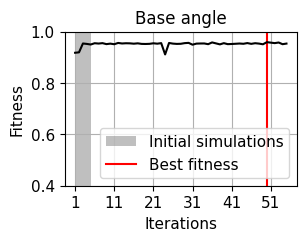

In [61]:
for index, row in df_t1.iterrows():
    fig1=plt.figure(figsize=(3,2))
    #fig, ax1 = plt.subplots(1, 1)
    ax1 = fig1.add_subplot(111)
    fitness_range_l=0.4
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=10
    init_sim_range=5
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1) 
    fitnes_range=np.linspace(fitness_range_l,fitness_range_h,fitness_range_step)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    #ax1.set_xticks([5,50],[5,50],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower right",prop={'size': 11})
    ax1.set_title("Base angle", fontsize=12)
    ax1.grid()
    #plt.savefig("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/figures/fitness_arm_axis_angle_2b.pdf",format="pdf",bbox_inches="tight")


## arm axis

Parameter set 0


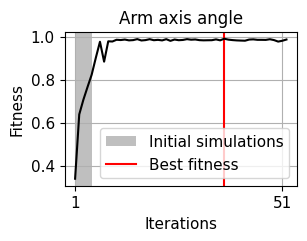

In [62]:
for index, row in df_t2.iterrows():
    fig1=plt.figure(figsize=(3,2))
    #fig, ax1 = plt.subplots(1, 1)
    ax1 = fig1.add_subplot(111)
    fitness_range_l=0.4
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=50
    init_sim_range=5
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1) 
    fitnes_range=np.linspace(fitness_range_l,fitness_range_h,fitness_range_step)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    #ax1.set_xticks([5,10],[5,10],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower right",prop={'size': 11})
    ax1.set_title("Arm axis angle", fontsize=12)
    ax1.grid()
    #plt.savefig("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/figures/fitness_arm_axis_angle_2b.pdf",format="pdf",bbox_inches="tight")


## HP sticky end

Parameter set 0


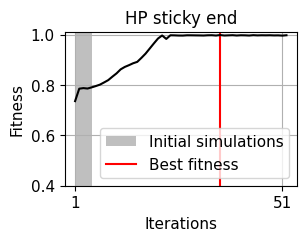

In [63]:
for index, row in df_t3.iterrows():
    fig1=plt.figure(figsize=(3,2))
    #fig, ax1 = plt.subplots(1, 1)
    ax1 = fig1.add_subplot(111)
    fitness_range_l=0.4
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=50
    init_sim_range=5
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1) 
    fitnes_range=np.linspace(fitness_range_l,fitness_range_h,fitness_range_step)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    #ax1.set_xticks([5,10],[5,10],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower right",prop={'size': 11})
    ax1.set_title("HP sticky end", fontsize=12)
    ax1.grid()
    #plt.savefig("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/figures/fitness_arm_axis_angle_2b.pdf",format="pdf",bbox_inches="tight")


## non hp sticky end

Parameter set 0


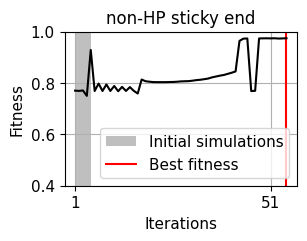

In [64]:
for index, row in df_t4.iterrows():
    fig1=plt.figure(figsize=(3,2))
    #fig, ax1 = plt.subplots(1, 1)
    ax1 = fig1.add_subplot(111)
    fitness_range_l=0.4
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=50
    init_sim_range=5
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1) 
    fitnes_range=np.linspace(fitness_range_l,fitness_range_h,fitness_range_step)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    #ax1.set_xticks([5,10],[5,10],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower right",prop={'size': 11})
    ax1.set_title("non-HP sticky end", fontsize=12)
    ax1.grid()
    #plt.savefig("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/figures/fitness_arm_axis_angle_2b.pdf",format="pdf",bbox_inches="tight")


## bound arms

Parameter set 0


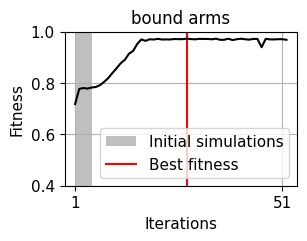

In [65]:
for index, row in df_t5.iterrows():
    fig1=plt.figure(figsize=(3,2))
    #fig, ax1 = plt.subplots(1, 1)
    ax1 = fig1.add_subplot(111)
    fitness_range_l=0.4
    fitness_range_h=1
    fitness_range_step=4
    iterations_step=50
    init_sim_range=5
    
    param_set=row["Set of indep params"]
    param_set_name="Parameter set "+str(param_set)
    print(param_set_name)
    iterations_l=np.arange(1,len(row["f train"])+1)
    param_value_range=(0.0,0.2,0.4,0.6,0.8,1.0) #(10**-22,2.5*10**-19,5*10**-19,7.5*10**-19,10**-18)  #=np.linspace(10**-22, 10**-18,5)  #np.arange(0,6,1) 
    fitnes_range=np.linspace(fitness_range_l,fitness_range_h,fitness_range_step)
    ax1.errorbar(iterations_l,row["f train"],color="black")
    id_max_fitnes=np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5,label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitnes],color="red",label="Best fitness")
    ax1.set_ylabel("Fitness",fontsize=11)
    ax1.set_xlabel("Iterations",fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step],iterations_l[::iterations_step],fontsize=11)
    #ax1.set_xticks([5,10],[5,10],fontsize=11)
    ax1.set_yticks(fitnes_range,fitnes_range ,fontsize=11)
    ax1.legend(loc="lower right",prop={'size': 11})
    ax1.set_title("bound arms", fontsize=12)
    ax1.grid()
    #plt.savefig("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/figures/fitness_arm_axis_angle_2b.pdf",format="pdf",bbox_inches="tight")


## base + arm axis

Parameter set 0


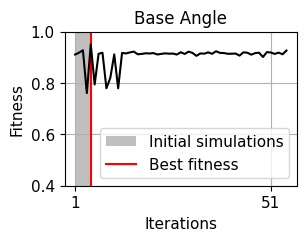

Parameter set 1


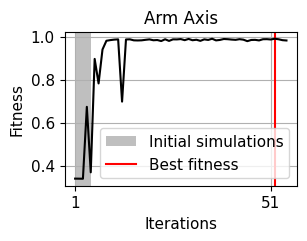

In [66]:
for index, row in df_t6.iterrows():
    fig1 = plt.figure(figsize=(3, 2))
    ax1 = fig1.add_subplot(111)
    
    fitness_range_l = 0.4
    fitness_range_h = 1
    fitness_range_step = 4
    iterations_step = 50
    init_sim_range = 5
    
    param_set = row["Set of indep params"]
    param_set_name = f"Parameter set {param_set}"
    print(param_set_name)
    
    iterations_l = np.arange(1, len(row["f train"]) + 1)
    param_value_range = (0.0, 0.2, 0.4, 0.6, 0.8, 1.0)
    fitness_range = np.round(np.linspace(fitness_range_l, fitness_range_h, fitness_range_step), 1)
    
    ax1.errorbar(iterations_l, row["f train"], color="black")
    id_max_fitness = np.argmax(row["f train"])
    
    ax1.axvspan(1, init_sim_range, facecolor='grey', alpha=0.5, label="Initial simulations")
    ax1.axvline(iterations_l[id_max_fitness], color="red", label="Best fitness")
    ax1.set_ylabel("Fitness", fontsize=11)
    ax1.set_xlabel("Iterations", fontsize=11)
    ax1.set_xticks(iterations_l[::iterations_step], iterations_l[::iterations_step], fontsize=11)
    ax1.set_yticks(fitness_range, fitness_range, fontsize=11)
    ax1.legend(loc="lower right", prop={'size': 11})
    
    # Dynamic title based on parameter set
    if param_set == 0:
        ax1.set_title("Base Angle", fontsize=12)
    elif param_set == 1:
        ax1.set_title("Arm Axis", fontsize=12)
    else:
        ax1.set_title(f"Parameter Set {param_set}", fontsize=12)
    
    ax1.grid()
    
    # if param_set == 0:
    #     plt.savefig("/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/figures/fitness_base_oppa_angle_2b.pdf", format="pdf", bbox_inches="tight")
    
    plt.show()


# Comparing fitness

['sim_ba_opt_1_245.h5']
Fitness base: 0.9476652879026688
['sim_ba_opt_1_246.h5']
Fitness base: 0.9585724325609197
['sim_ba_opt_1_247.h5']
Fitness base: 0.9567963834349804
['sim_ba_opt_1_248.h5']
Fitness base: 0.9557943706859631
['sim_ba_opt_1_249.h5']
Fitness base: 0.9605560286272815


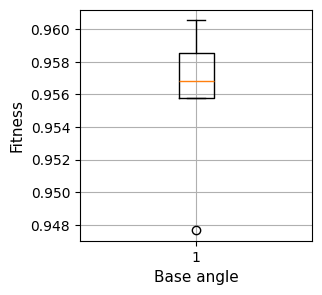

###########################
###########################
###########################


In [67]:
folder_names_angle_eval = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"
names_ini1 = "sim_ba_opt_1_"
names_angle_eval = [names_ini1 + str(l + 245) + ".h5" for l in range(5)]
names_angles = ["Base angle"]

# Process the angles
fitness_base_list=[]
for i in range(len(names_angle_eval)):
    base_angle_distr_ex_1, values_angle_base_ex_1= cg_angle_distr_1_1_ba(
        folder=folder_names_angle_eval,
        names_sim_repeat=[names_angle_eval[i]],
        t_skip=300,
        t_lim=None,
        t_step=1
    )
    print([names_angle_eval[i]])
    
    # List of angles to be evaluated
    list_angles_eval = [values_angle_base_ex_1]

    # Calculate and print fitness for the base angle
    fitness_base = gt_1_1(base_angle_distr_ex_1, base_angle_distr_target)
    print("Fitness base:", fitness_base)
    fitness_base_list.append(fitness_base)

    # Generate boxplot for the base angle
fig, ax = plt.subplots(figsize=(3, 3))
ax.boxplot(fitness_base_list)  # Convert to degrees
ax.set_ylabel("Fitness", fontsize=11)
ax.set_xlabel("Base angle", fontsize=11)
ax.grid()
plt.show()

print("###########################")
print("###########################")
print("###########################")

['sim_aa_opt_1_245.h5']
Fitness arm axis: 0.9811335579723143
['sim_aa_opt_1_246.h5']
Fitness arm axis: 0.9776778666301729
['sim_aa_opt_1_247.h5']
Fitness arm axis: 0.9635893523454309
['sim_aa_opt_1_248.h5']
Fitness arm axis: 0.9678899647718918
['sim_aa_opt_1_249.h5']
Fitness arm axis: 0.9751961303335301


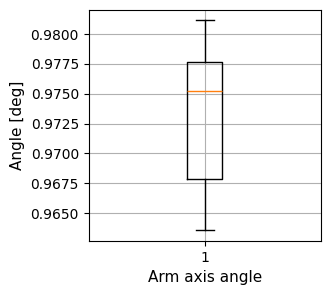

###########################
###########################
###########################


In [68]:
folder_names_angle_eval = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"
names_ini1 = "sim_aa_opt_1_"
names_angle_eval = [names_ini1 + str(l + 245) + ".h5" for l in range(5)] # 96
names_angles = ["Arm axis angle"]

# Process the angles
fitness_arm_axis_list=[]
for i in range(len(names_angle_eval)):
    arm_axis_angle_distr_ex_1, values_angle_arm_axis_ex_1= cg_angle_distr_1_1_aa(
        folder=folder_names_angle_eval,
        names_sim_repeat=[names_angle_eval[i]],
        t_skip=300,
        t_lim=None,
        t_step=1
    )
    print([names_angle_eval[i]])

    # List of angles to be evaluated
    list_angles_eval = [values_angle_arm_axis_ex_1]

    # Calculate and print fitness for the arm_axis angle
    fitness_arm_axis = gt_1_1(arm_axis_angle_distr_ex_1, arm_axis_angle_distr_target)
    print("Fitness arm axis:", fitness_arm_axis)
    fitness_arm_axis_list.append(fitness_arm_axis)

# Generate boxplot for the arm_axis angle
fig, ax = plt.subplots(figsize=(3, 3))
ax.boxplot(fitness_arm_axis_list)
ax.set_ylabel("Angle [deg]", fontsize=11)
ax.set_xlabel("Arm axis angle", fontsize=11)
ax.grid()
plt.show()

print("###########################")
print("###########################")
print("###########################")

erst aa, dann ba

['sim_aa_opt_1_245.h5']
Fitness base: 0.8937901670170034
['sim_aa_opt_1_246.h5']
Fitness base: 0.9147933289162902
['sim_aa_opt_1_247.h5']
Fitness base: 0.9123103640297595
['sim_aa_opt_1_248.h5']
Fitness base: 0.9307008049187109
['sim_aa_opt_1_249.h5']
Fitness base: 0.9021244855042647
['sim_aa_opt_1_245.h5']
Fitness arm axis: 0.9733679996396485
['sim_aa_opt_1_246.h5']
Fitness arm axis: 0.9766766169684422
['sim_aa_opt_1_247.h5']
Fitness arm axis: 0.9800188809495495
['sim_aa_opt_1_248.h5']
Fitness arm axis: 0.9746234790312394
['sim_aa_opt_1_249.h5']
Fitness arm axis: 0.9845403702523805


/tmp/ipykernel_211591/3406967331.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Base angle", "Arm axis angle", "Average fitness"])


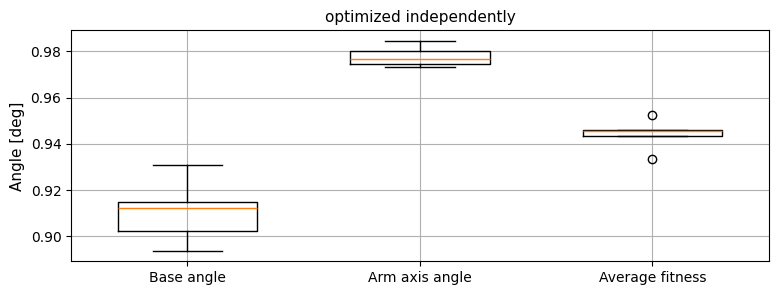

In [84]:
# Define the necessary variables and parameters
folder_names_angle_eval_ba = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"
folder_names_angle_eval_aa = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"
names_ini1_ba = "sim_ba_seq_opt_1_"
names_ini1_aa = "sim_aa_seq_opt_1_"
names_angle_eval_ba = [names_ini1_ba + str(l + 245) + ".h5" for l in range(5)]
names_angle_eval_aa = [names_ini1_aa + str(l + 245) + ".h5" for l in range(5)]

# Initialize lists to store fitness scores
fitness_base_list = []
fitness_arm_axis_list = []

# Process the base angles
for i in range(len(names_angle_eval_ba)):
    base_angle_distr_ex_1, values_angle_base_ex_1 = cg_angle_distr_1_1_ba(
        folder=folder_names_angle_eval_ba,
        names_sim_repeat=[names_angle_eval_ba[i]],
        t_skip=300,
        t_lim=None,
        t_step=1
    )
    print([names_angle_eval[i]])
    
    # Calculate and store fitness for the base angle
    fitness_base = gt_1_1(base_angle_distr_ex_1, base_angle_distr_target)
    fitness_base_list.append(fitness_base)
    print("Fitness base:", fitness_base)

# Process the arm axis angles
for i in range(len(names_angle_eval_aa)):
    arm_axis_angle_distr_ex_1, values_angle_arm_axis_ex_1 = cg_angle_distr_1_1_aa(
        folder=folder_names_angle_eval_aa,
        names_sim_repeat=[names_angle_eval_aa[i]],
        t_skip=300,
        t_lim=None,
        t_step=1
    )
    print([names_angle_eval[i]])

    # Calculate and store fitness for the arm axis angle
    fitness_arm_axis = gt_1_1(arm_axis_angle_distr_ex_1, arm_axis_angle_distr_target)
    fitness_arm_axis_list.append(fitness_arm_axis)
    print("Fitness arm axis:", fitness_arm_axis)

# Calculate the average fitness score
average_fitness_scores = ( np.array(fitness_base_list) + np.array(fitness_arm_axis_list) ) / 2

# Generiere Boxplots
fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title("optimized independently", fontsize=11)
ax.set_ylabel("Angle [deg]", fontsize=11)
#ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["Base angle", "Arm axis angle", "Average fitness"])
ax.grid()

# Boxplot base angle
ax.boxplot(fitness_base_list, positions=[1], widths=0.6)

# Boxplot arm axis
ax.boxplot(fitness_arm_axis_list, positions=[2], widths=0.6)

# Boxplot average
ax.boxplot(average_fitness_scores, positions=[3], widths=0.6)

output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
filename = f"{output_dir}/opt_indep_aa_ba.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

erst ba, dann aa

['sim_aa_opt_1_245.h5']
Fitness base: 0.9476652879026688
['sim_aa_opt_1_246.h5']
Fitness base: 0.9585724325609197
['sim_aa_opt_1_247.h5']
Fitness base: 0.9567963834349804
['sim_aa_opt_1_248.h5']
Fitness base: 0.9557943706859631
['sim_aa_opt_1_249.h5']
Fitness base: 0.9605560286272815
['sim_aa_opt_1_245.h5']
Fitness arm axis: 0.9811335579723143
['sim_aa_opt_1_246.h5']
Fitness arm axis: 0.9776778666301729
['sim_aa_opt_1_247.h5']
Fitness arm axis: 0.9635893523454309
['sim_aa_opt_1_248.h5']
Fitness arm axis: 0.9678899647718918
['sim_aa_opt_1_249.h5']
Fitness arm axis: 0.9751961303335301


/tmp/ipykernel_211591/2446551884.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Base angle", "Arm axis angle", "Average fitness"])


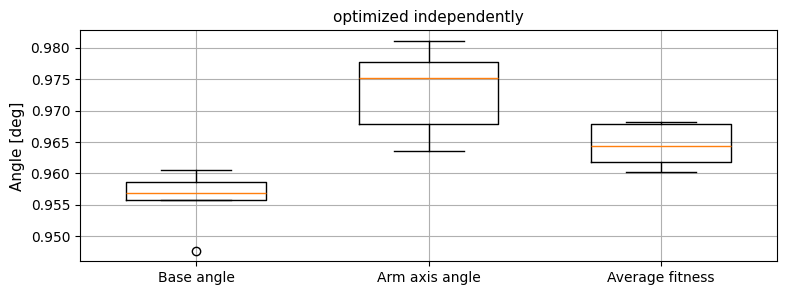

In [82]:
# Define the necessary variables and parameters
folder_names_angle_eval_ba = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"
folder_names_angle_eval_aa = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"
names_ini1_ba = "sim_ba_opt_1_"
names_ini1_aa = "sim_aa_opt_1_"
names_angle_eval_ba = [names_ini1_ba + str(l + 245) + ".h5" for l in range(5)]
names_angle_eval_aa = [names_ini1_aa + str(l + 245) + ".h5" for l in range(5)]

# Initialize lists to store fitness scores
fitness_base_list = []
fitness_arm_axis_list = []

# Process the base angles
for i in range(len(names_angle_eval_ba)):
    base_angle_distr_ex_1, values_angle_base_ex_1 = cg_angle_distr_1_1_ba(
        folder=folder_names_angle_eval_ba,
        names_sim_repeat=[names_angle_eval_ba[i]],
        t_skip=300,
        t_lim=None,
        t_step=1
    )
    print([names_angle_eval[i]])
    
    # Calculate and store fitness for the base angle
    fitness_base = gt_1_1(base_angle_distr_ex_1, base_angle_distr_target)
    fitness_base_list.append(fitness_base)
    print("Fitness base:", fitness_base)

# Process the arm axis angles
for i in range(len(names_angle_eval_aa)):
    arm_axis_angle_distr_ex_1, values_angle_arm_axis_ex_1 = cg_angle_distr_1_1_aa(
        folder=folder_names_angle_eval_aa,
        names_sim_repeat=[names_angle_eval_aa[i]],
        t_skip=300,
        t_lim=None,
        t_step=1
    )
    print([names_angle_eval[i]])

    # Calculate and store fitness for the arm axis angle
    fitness_arm_axis = gt_1_1(arm_axis_angle_distr_ex_1, arm_axis_angle_distr_target)
    fitness_arm_axis_list.append(fitness_arm_axis)
    print("Fitness arm axis:", fitness_arm_axis)

# Calculate the average fitness score
average_fitness_scores = ( np.array(fitness_base_list) + np.array(fitness_arm_axis_list) ) / 2

# Generiere Boxplots
fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title("optimized independently", fontsize=11)
ax.set_ylabel("Angle [deg]", fontsize=11)
#ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["Base angle", "Arm axis angle", "Average fitness"])
ax.grid()

# Boxplot base angle
ax.boxplot(fitness_base_list, positions=[1], widths=0.6)

# Boxplot arm axis
ax.boxplot(fitness_arm_axis_list, positions=[2], widths=0.6)

# Boxplot average
ax.boxplot(average_fitness_scores, positions=[3], widths=0.6)

output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
filename = f"{output_dir}/opt_indep_ba_aa.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

ba + aa

['sim_aa_opt_1_245.h5']
Fitness base: 0.907565447314935
['sim_aa_opt_1_246.h5']
Fitness base: 0.9092209812597006
['sim_aa_opt_1_247.h5']
Fitness base: 0.9240185450965778
['sim_aa_opt_1_248.h5']
Fitness base: 0.9131196405828915
['sim_aa_opt_1_249.h5']
Fitness base: 0.9295518307857144
['sim_aa_opt_1_245.h5']
Fitness arm axis: 0.969064702928971
['sim_aa_opt_1_246.h5']
Fitness arm axis: 0.9677606952212219
['sim_aa_opt_1_247.h5']
Fitness arm axis: 0.9796132729154037
['sim_aa_opt_1_248.h5']
Fitness arm axis: 0.9827815668808435
['sim_aa_opt_1_249.h5']
Fitness arm axis: 0.980775252367347


/tmp/ipykernel_211591/4163285171.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Base angle", "Arm axis angle", "Average fitness"])


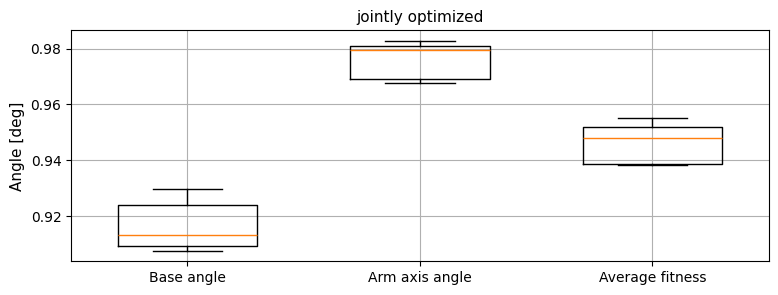

In [83]:
# Define the necessary variables and parameters
folder_names_angle_eval_ba_aa = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/"
names_ini1_ba_aa = "sim_ba_aa_seq_opt_1_"

names_angle_eval_ba = [names_ini1_ba_aa + str(l + 245) + ".h5" for l in range(5)]
names_angle_eval_aa = [names_ini1_ba_aa + str(l + 245) + ".h5" for l in range(5)]

# Initialize lists to store fitness scores
fitness_base_list = []
fitness_arm_axis_list = []

# Process the base angles
for i in range(len(names_angle_eval_ba)):
    base_angle_distr_ex_1, values_angle_base_ex_1 = cg_angle_distr_1_1_ba(
        folder=folder_names_angle_eval_ba_aa,
        names_sim_repeat=[names_angle_eval_ba[i]],
        t_skip=300,
        t_lim=None,
        t_step=1
    )
    print([names_angle_eval[i]])
    
    # Calculate and store fitness for the base angle
    fitness_base = gt_1_1(base_angle_distr_ex_1, base_angle_distr_target)
    fitness_base_list.append(fitness_base)
    print("Fitness base:", fitness_base)

# Process the arm axis angles
for i in range(len(names_angle_eval_aa)):
    arm_axis_angle_distr_ex_1, values_angle_arm_axis_ex_1 = cg_angle_distr_1_1_aa(
        folder=folder_names_angle_eval_ba_aa,
        names_sim_repeat=[names_angle_eval_aa[i]],
        t_skip=300,
        t_lim=None,
        t_step=1
    )
    print([names_angle_eval[i]])
    
    # Calculate and store fitness for the arm axis angle
    fitness_arm_axis = gt_1_1(arm_axis_angle_distr_ex_1, arm_axis_angle_distr_target)
    fitness_arm_axis_list.append(fitness_arm_axis)
    print("Fitness arm axis:", fitness_arm_axis)

# Calculate the average fitness score
average_fitness_scores = ( np.array(fitness_base_list) + np.array(fitness_arm_axis_list) ) / 2

# Generiere Boxplots
fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title("jointly optimized", fontsize=11)
ax.set_ylabel("Angle [deg]", fontsize=11)
#ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["Base angle", "Arm axis angle", "Average fitness"])
ax.grid()

# Boxplot base angle
ax.boxplot(fitness_base_list, positions=[1], widths=0.6)

# Boxplot arm axis
ax.boxplot(fitness_arm_axis_list, positions=[2], widths=0.6)

# Boxplot average
ax.boxplot(average_fitness_scores, positions=[3], widths=0.6)

output_dir = "/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/output_graphics/"
filename = f"{output_dir}/opt_joint_ba_aa.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()



# Run simulation with optimzed parameters


## base, arm, axis

In [ ]:
#copy of sim params
run_sim_1_input_opt_1=run_sim_1_input.copy()

#update parameters optimized in previous step
run_sim_1_input_opt_1.update(dict_opt_params_all_steps)

In [ ]:
run_sim_1_input_opt_1["folder"]="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
run_sim_1_input_opt_1["name"]="y_opt_test_1_"
run_sim_1_input_opt_1["add_num_1"]=0

In [ ]:
#run multiple copys of sim in parallel
gen_sim_list=[]
gen_sim_param_list=[]

for i in range(5):
    gen_sim_list.append(run_sim_1)
    run_sim_1_input_c=run_sim_1_input_opt_1.copy()
    run_sim_1_input_c["add_num_1"]=i
    gen_sim_param_list.append(run_sim_1_input_c)
    
run_p_dict(gen_sim_list,gen_sim_param_list)

In [ ]:
%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"

names_ini1="y_opt_test_1_"
names_angle_eval=[[names_ini1+str(l+0)+".h5" for l in range(5)]] #96

names_angles=["Base angle", "Link angle","Arm axis angle"]
for i in range(len(names_angle_eval)):
    base_angle_distr_ex_1,link_angle_distr_ex_1,arm_axis_angle_distr_ex_1,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1=cg_angle_distr_1_3_ba_aa_la(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    list_angles_eval=[values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1]
    
    print("Fitness arm axis:", gt_1_1(arm_axis_angle_distr_ex_1,arm_axis_angle_distr_target))
    print("Fitness base:", gt_1_1(base_angle_distr_ex_1,base_angle_distr_target))
    print("Fitness link:", gt_1_1(link_angle_distr_ex_1,link_angle_distr_target))
    
    for j in range(len(list_angles_eval)):
        fig1=plt.figure(figsize=(3,3))
        ax1 = fig1.add_subplot(111)
        if names_angles[j]=="Arm axis angle":
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='bar',color="grey")[0]
            plt.xlim(-1,20)
        else:
            sel_target_angle_distr=ax1.hist(list_values_target_angles_1[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
            sel_angle_distr=ax1.hist(list_angles_eval[j]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
        print(names_angles[j])
        ax1.set_ylabel("Normalized frequency",fontsize=11)
        ax1.set_xlabel("Angle [deg]",fontsize=11)
        ax1.grid()
        plt.show()
    print("###########################")
    print("###########################")
    print("###########################")

## hp angle

In [ ]:
#copy of sim params
run_sim_1_input_opt_2=run_sim_1_input.copy()

#update parameters optimized in previous step
run_sim_1_input_opt_2.update(dict_opt_params_all_steps)

In [ ]:
run_sim_1_input_opt_2["folder"]="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
run_sim_1_input_opt_2["name"]="y_opt_test_hp_1_"
run_sim_1_input_opt_2["add_num_1"]=0
run_sim_1_input_opt_2["use_y_1_HP_template"]=True

In [ ]:
#run multiple copys of sim in parallel
gen_sim_list=[]
gen_sim_param_list=[]

for i in range(5):
    gen_sim_list.append(run_sim_1)
    run_sim_1_input_c=run_sim_1_input_opt_2.copy()
    run_sim_1_input_c["add_num_1"]=i
    gen_sim_param_list.append(run_sim_1_input_c)
    
run_p_dict(gen_sim_list,gen_sim_param_list)

In [ ]:
%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"

names_ini1="y_opt_test_hp_1_"
names_angle_eval=[[names_ini1+str(l+0)+".h5" for l in range(5)]]

names_angles="Link HP angle"
for i in range(len(names_angle_eval)):
    link_angle_distr_ex_1, values_angle_link_ex1=cg_angle_distr_1_1_hp(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    
    fig1=plt.figure(figsize=(3,3))
    ax1 = fig1.add_subplot(111)

    sel_target_angle_distr=ax1.hist(list_values_target_angles_1[3]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
    sel_angle_distr=ax1.hist(values_angle_link_ex1*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
    print(names_angles)
    print("Fitness hp:",gt_1_1(sel_angle_distr,sel_target_angle_distr))
    ax1.set_ylabel("Normalized frequency",fontsize=11)
    ax1.set_xlabel("Angle [deg]",fontsize=11)
    ax1.grid()
    plt.show()
    print("###########################")
    print("###########################")
    print("###########################")


## bound arm angles

In [ ]:
#copy of sim params
run_sim_1_input_opt_3=run_sim_1_input.copy()

#update parameters optimized in previous step
run_sim_1_input_opt_3.update(dict_opt_params_all_steps)

In [ ]:
run_sim_1_input_opt_3["folder"]="/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/opt_test_2/"
run_sim_1_input_opt_3["name"]="x_opt_test_bm_1_"
run_sim_1_input_opt_3["add_num_1"]=0
run_sim_1_input_opt_3["checkpoint_path"]="/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/two_fused_motifs_checkpoint/"


In [ ]:
#run multiple copys of sim in parallel
gen_sim_list=[]
gen_sim_param_list=[]

for i in range(5):
    gen_sim_list.append(run_sim_1)
    run_sim_1_input_c=run_sim_1_input_opt_3.copy()
    run_sim_1_input_c["add_num_1"]=i
    gen_sim_param_list.append(run_sim_1_input_c)
    
run_p_dict(gen_sim_list,gen_sim_param_list)

In [ ]:
%%time

folder_names_angle_eval="/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/opt_test_2/"

names_ini1="x_opt_test_bm_1_"
names_angle_eval=[[names_ini1+str(l+0)+".h5" for l in range(5)]]

names_angles="Bound motifs angle"
for i in range(len(names_angle_eval)):
    angle_ds_fused_link_distr_ex_1, values_angle_ds_fused_link_ex1=cg_angle_distr_1_1_bm(folder=folder_names_angle_eval,names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    
    fig1=plt.figure(figsize=(3,3))
    ax1 = fig1.add_subplot(111)

    sel_target_angle_distr=ax1.hist(list_values_target_angles_1[5]*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='step',ls="-",color="red")[0]
    sel_angle_distr=ax1.hist(values_angle_ds_fused_link_ex1*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',color="grey")[0]
    print(names_angles)
    print("Fitness ba:",gt_1_1(sel_angle_distr,sel_target_angle_distr))
    ax1.set_ylabel("Normalized frequency",fontsize=11)
    ax1.set_xlabel("Angle [deg]",fontsize=11)
    ax1.grid()
    plt.show()
    print("###########################")
    print("###########################")
    print("###########################")


# Compare optimized and unoptimized simulations

## Arm axis angle

In [ ]:
%%time
#guess parameter in middle of range
#folder_names_init_sim="ML_parameter_opt_1/NCG_X_motif_4/unopt_test_2/"
#names_ini1="x_test_1_"

#sim from optimization
folder_names_init_sim="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
names_ini1="sim_aa_opt_1_"

#opt simulations
folder_names_opt_sim1="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
#folder_names_opt_sim2="ML_parameter_opt_1/NCG_X_motif_3/opt_test_2/"
#folder_names_opt_sim3="ML_parameter_opt_1/NCG_X_motif_3/opt_test_3/"

names_opt1="y_opt_test_1_"
#names_opt2="x_opt_test_2_"
#names_opt3="x_opt_test_3_"

names_angle_eval=[[names_ini1+str(l+11)+".h5" for l in range(5)]
                 ,[names_opt1+str(l+0)+".h5" for l in range(5)]]

folders_angle_eval=[folder_names_init_sim,
                   folder_names_opt_sim1]

colours_l=["tab:blue","red"]
names_l=["First prediction","Optimised"]

fig1=plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111)
sel_target_angle_distr=ax1.hist(values_angle_arm_axis_target*180/np.pi,bins=np.arange(0,190,1),density=True, histtype='bar',ls="-",color="grey",label="Target")[0]

for i in range(len(names_angle_eval)):
    base_angle_distr_ex_1,link_angle_distr_ex_1,arm_axis_angle_distr_ex_1,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1=cg_angle_distr_1_3_ba_aa_la(folder=folders_angle_eval[i],names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    list_angles_eval=[values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1]

    sel_angle_distr=ax1.hist(values_angle_arm_axis_ex_1*180/np.pi,bins=np.arange(0,190,1),density=True,color=colours_l[i], histtype='step',label=names_l[i])[0]


plt.xlim(-1,25)
ax1.legend(loc="upper right",prop={'size': 11})
ax1.set_ylabel("Normalised frequency",fontsize=11)
ax1.set_xlabel("Angle [deg]",fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

ax1.grid()

#plt.savefig("ML_parameter_opt_1/NCG_X_motif_4/figures/opt_arm_axis_angle_3.pdf",format="pdf",bbox_inches="tight")



## Base angle

In [ ]:
%%time

#guess parameter in middle of range
#folder_names_init_sim="ML_parameter_opt_1/NCG_X_motif_4/unopt_test_2/"
#names_ini1="x_test_1_"

#sim from optimization
folder_names_init_sim="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
names_ini1="sim_ba_la_opt_1_"

#opt simulations
folder_names_opt_sim1="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
#folder_names_opt_sim2="ML_parameter_opt_1/NCG_X_motif_3/opt_test_2/"
#folder_names_opt_sim3="ML_parameter_opt_1/NCG_X_motif_3/opt_test_3/"

names_opt1="y_opt_test_1_"
#names_opt2="x_opt_test_2_"
#names_opt3="x_opt_test_3_"

names_angle_eval=[[names_ini1+str(l+11)+".h5" for l in range(5)]
                 ,[names_opt1+str(l+0)+".h5" for l in range(5)]]

folders_angle_eval=[folder_names_init_sim,
                   folder_names_opt_sim1]

colours_l=["tab:blue","red"]
names_l=["First prediction","Optimised"]

fig1=plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111)
sel_target_angle_distr=ax1.hist(values_angle_base_target*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',ls="-",color="grey",label="Target")[0]


for i in range(len(names_angle_eval)):
    base_angle_distr_ex_1,link_angle_distr_ex_1,arm_axis_angle_distr_ex_1,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1=cg_angle_distr_1_3_ba_aa_la(folder=folders_angle_eval[i],names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    list_angles_eval=[values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1]

    sel_angle_distr=ax1.hist(values_angle_base_ex_1*180/np.pi,bins=np.arange(0,190,5),density=True, color=colours_l[i],histtype='step',label=names_l[i])[0]

#plt.xlim(-1,50)
ax1.legend(loc="lower center",prop={'size': 11})
ax1.set_ylabel("Normalised frequency",fontsize=11)
ax1.set_xlabel("Angle [deg]",fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax1.grid()

#plt.savefig("ML_parameter_opt_1/NCG_X_motif_4/figures/opt_base_angle_3.pdf",format="pdf",bbox_inches="tight")




## Oppa angle

In [ ]:
%%time
#guess parameter in middle of range
#folder_names_init_sim="ML_parameter_opt_1/NCG_X_motif_4/unopt_test_2/"
#names_ini1="x_test_1_"

#sim from optimization
folder_names_init_sim="/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/ba_oa_la_opt_2/"
names_ini1="sim_ba_oa_la_opt_1_"

#opt simulations
folder_names_opt_sim1="/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/opt_test_2/"
#folder_names_opt_sim2="ML_parameter_opt_1/NCG_X_motif_3/opt_test_2/"
#folder_names_opt_sim3="ML_parameter_opt_1/NCG_X_motif_3/opt_test_3/"

names_opt1="x_opt_test_1_"
#names_opt2="x_opt_test_2_"
#names_opt3="x_opt_test_3_"

names_angle_eval=[[names_ini1+str(l+81)+".h5" for l in range(5)]
                 ,[names_opt1+str(l+0)+".h5" for l in range(5)]]

folders_angle_eval=[folder_names_init_sim,
                   folder_names_opt_sim1]

colours_l=["tab:blue","red"]
names_l=["First prediction","Optimised"]


fig1=plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111)
sel_target_angle_distr=ax1.hist(values_angle_oppa_target*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',ls="-",color="grey",label="Target")[0]

for i in range(len(names_angle_eval)):
    base_angle_distr_ex_1,link_angle_distr_ex_1,arm_axis_angle_distr_ex_1,oppa_angle_distr_ex_1     ,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1,values_angle_oppa_ex_test_1=cg_angle_distr_1_4_ba_aa_oa_la(folder=folders_angle_eval[i],names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    list_angles_eval=[values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1,values_angle_oppa_ex_test_1]

    sel_angle_distr=ax1.hist(values_angle_oppa_ex_test_1*180/np.pi,bins=np.arange(0,190,5),density=True,color=colours_l[i], histtype='step',label=names_l[i])[0]


#plt.xlim(-1,50)
ax1.legend(loc="upper left",prop={'family': 'Arial','size': 11})
ax1.set_ylabel("Normalised frequency",fontsize=11)
ax1.set_xlabel("Angle [deg]",fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax1.grid()


#plt.savefig("ML_parameter_opt_1/NCG_X_motif_4/figures/opt_oppa_angle_3.pdf",format="pdf",bbox_inches="tight")



## Link angle

In [ ]:
%%time
#guess parameter in middle of range
#folder_names_init_sim="ML_parameter_opt_1/NCG_X_motif_4/unopt_test_2/"
#names_ini1="x_test_1_"

#sim from optimization
folder_names_init_sim="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
names_ini1="sim_ba_la_opt_1_"

#opt simulations
folder_names_opt_sim1="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
#folder_names_opt_sim2="ML_parameter_opt_1/NCG_X_motif_3/opt_test_2/"
#folder_names_opt_sim3="ML_parameter_opt_1/NCG_X_motif_3/opt_test_3/"

names_opt1="y_opt_test_1_"
#names_opt2="x_opt_test_2_"
#names_opt3="x_opt_test_3_"

names_angle_eval=[[names_ini1+str(l+11)+".h5" for l in range(5)]
                 ,[names_opt1+str(l+0)+".h5" for l in range(5)]]

folders_angle_eval=[folder_names_init_sim,
                   folder_names_opt_sim1]

colours_l=["tab:blue","red"]
names_l=["First prediction","Optimised"]


fig1=plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111)
sel_target_angle_distr=ax1.hist(values_angle_link_target*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',ls="-",color="grey",label="Target")[0]

for i in range(len(names_angle_eval)):
    base_angle_distr_ex_1,link_angle_distr_ex_1,arm_axis_angle_distr_ex_1,values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1=cg_angle_distr_1_3_ba_aa_la(folder=folders_angle_eval[i],names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)
    list_angles_eval=[values_angle_base_ex_1,values_angle_link_ex_1,values_angle_arm_axis_ex_1]

    sel_angle_distr=ax1.hist(values_angle_link_ex_1*180/np.pi,bins=np.arange(0,190,5),density=True, color=colours_l[i],histtype='step',label=names_l[i])[0]


plt.xlim(-1,110)
ax1.legend(loc="upper right",prop={'size': 11})
ax1.set_ylabel("Normalised frequency",fontsize=11)
ax1.set_xlabel("Angle [deg]",fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax1.grid()


#plt.savefig("ML_parameter_opt_1/NCG_X_motif_4/figures/opt_link_angle_3.pdf",format="pdf",bbox_inches="tight")



## HP link angle

In [ ]:
%%time

#guess parameter in middle of range
#folder_names_init_sim="ML_parameter_opt_1/NCG_X_motif_4/unopt_test_2/"
#names_ini1="x_test_hp_1_"

#sim from optimization
folder_names_init_sim="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
names_ini1="sim_hp_opt_1_"

#opt simulations
folder_names_opt_sim1="/home/xenia/Masterthesis_ReaDDy/modified_code/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/"
#folder_names_opt_sim2="ML_parameter_opt_1/NCG_X_motif_3/opt_test_2/"
#folder_names_opt_sim3="ML_parameter_opt_1/NCG_X_motif_3/opt_test_3/"

names_opt1="y_opt_test_hp_1_"
#names_opt2="x_opt_test_hp_2_"
#names_opt3="x_opt_test_hp_3_"

names_angle_eval=[[names_ini1+str(l+11)+".h5" for l in range(5)]
                 ,[names_opt1+str(l+0)+".h5" for l in range(5)]]

folders_angle_eval=[folder_names_init_sim,
                   folder_names_opt_sim1]

colours_l=["tab:blue","red"]
names_l=["First prediction","Optimised"]


fig1=plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111)
sel_target_angle_distr=ax1.hist(values_angle_link_HP_target*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',ls="-",color="grey",label="Target")[0]

for i in range(len(names_angle_eval)):
    link_angle_distr_ex_1, values_angle_link_ex1=cg_angle_distr_1_1_hp(folder=folders_angle_eval[i],names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)

    sel_angle_distr=ax1.hist(values_angle_link_ex1*180/np.pi,bins=np.arange(0,190,5),density=True,color=colours_l[i], histtype='step',label=names_l[i])[0]


plt.xlim(-1,55)
ax1.legend(loc="upper right",prop={'size': 11})
ax1.set_ylabel("Normalised frequency",fontsize=11)
ax1.set_xlabel("Angle [deg]",fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax1.grid()


#plt.savefig("ML_parameter_opt_1/NCG_X_motif_4/figures/opt_HP_link_angle_3.pdf",format="pdf",bbox_inches="tight")



## bound arms angle

In [ ]:
%%time

#guess parameter in middle of range
#folder_names_init_sim="ML_parameter_opt_1/NCG_X_motif_4/unopt_test_2/"
#names_ini1="x_test_ba_1_"

#sim from optimization
folder_names_init_sim="/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/bm_opt_2/"
names_ini1="sim_bm_opt_1_"

#opt simulations
folder_names_opt_sim1="/home/xenia/Masterthesis_ReaDDy/Nanomotif_Coarse_Graining_1/NCG_X_motif_4/opt_test_2/"
#folder_names_opt_sim2="ML_parameter_opt_1/NCG_X_motif_3/opt_test_2/"
#folder_names_opt_sim3="ML_parameter_opt_1/NCG_X_motif_3/opt_test_3/"

names_opt1="x_opt_test_ba_1_"
#names_opt2="x_opt_test_ba_2_"
#names_opt3="x_opt_test_ba_3_"

names_angle_eval=[[names_ini1+str(l+11)+".h5" for l in range(5)]
                 ,[names_opt1+str(l+0)+".h5" for l in range(5)]]

folders_angle_eval=[folder_names_init_sim,
                   folder_names_opt_sim1]

colours_l=["tab:blue","red"]
names_l=["First prediction","Optimised"]


fig1=plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111)
sel_target_angle_distr=ax1.hist(values_angle_ds_fused_link_target*180/np.pi,bins=np.arange(0,190,5),density=True, histtype='bar',ls="-",color="grey",label="Target")[0]

for i in range(len(names_angle_eval)):
    angle_ds_fused_link_distr_ex_1, values_angle_ds_fused_link_ex1=cg_angle_distr_1_1_bm(folder=folders_angle_eval[i],names_sim_repeat=names_angle_eval[i],t_skip=300,t_lim=None,t_step=1)

    sel_angle_distr=ax1.hist(values_angle_ds_fused_link_ex1*180/np.pi,bins=np.arange(0,190,5),density=True,color=colours_l[i], histtype='step',label=names_l[i])[0]


plt.xlim(-1,55)
ax1.legend(loc="upper right",prop={'family': 'Arial','size': 11})
ax1.set_ylabel("Normalised frequency",fontsize=11)
ax1.set_xlabel("Angle [deg]",fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
ax1.grid()


#plt.savefig("ML_parameter_opt_1/NCG_X_motif_4/figures/opt_bound_arms_angle_3.pdf",format="pdf",bbox_inches="tight")



# TCL 

In [ ]:
#traj_mech=readdy.Trajectory("/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/bay_opt_sim/sim_bm_opt_1_1.h5")
traj_mech=readdy.Trajectory("/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/sim_bm_opt_2_1.h5")


In [ ]:
radii={}
for i in range(len(all_types)):
    radii[all_types[i]]=1.36
traj_mech.convert_to_xyz(particle_radii=radii)

In [ ]:
#tcl_file_gen_1=tcl_file_gen("sim_bm_opt_1_1.h5.xyz","120 120 120")
tcl_file_gen_1=tcl_file_gen("sim_bm_opt_2_1.h5.xyz","120 120 120")

In [ ]:
tcl_file_gen_1

In [ ]:
#np.savetxt("/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/bay_opt_sim/tcl_sim_bm_opt_1_1.xyz.tcl",tcl_file_gen_1,delimiter=" ", fmt="%s")

np.savetxt("/home/xenia/Masterthesis_ReaDDy/Bayes_opt_nanomotifs/Bayes_opt_Y_motif_short/04-15_Bay_Opt/sim/sim_bm_opt_2_1.xyz.tcl",tcl_file_gen_1,delimiter=" ", fmt="%s")
